In [ ]:
import random
random.seed(666)

import math
import numpy as np
import pandas as pd
import logging

import torch
from torch import nn
from torch.nn import functional as F
torch.manual_seed(666)

from tqdm.auto import tqdm, trange
from tqdm.contrib import tenumerate
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score 

from platform import python_version
print(python_version())
print(torch.__version__)

3.7.13
1.12.0+cu113


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu") 
print(device)

cuda:0


Helper Functions

In [ ]:
def summarize(data):
    print(f'number of trials: {len(data)}')
    
    seq_lens = [len(seq) for seq in data]
    print(f'spike sequence length range: {min(seq_lens)} ~ {max(seq_lens)}')
    
    ranges = []
    for i in range(4):
        start = min([seq[0, i]  for seq in data])
        end   = max([seq[-1, i] for seq in data])
        ranges.append((start, end))

    print(f'time range (sec): {ranges[0][0]:.3f} ~ {ranges[0][1]:.3f}')
    print(f'x range:   {ranges[1][0]:.3f} ~ {ranges[1][1]:.3f}')
    print(f'z range:   {ranges[2][0]:.3f} ~ {ranges[2][1]:.3f}')
    print(f'amp range:   {ranges[3][0]:.3f} ~ {ranges[3][1]:.3f}')

    # return max(seq_lens) # Max sequence length among trials

In [ ]:
def flatten_for_auc(xss):
    return [x.cpu().detach().numpy() for xs in xss for x in xs]

def flatten_for_acc(xss):
    return [x.cpu().detach().numpy().argmax() for xs in xss for x in xs]

Load Neural Data

In [ ]:
'''
cov_idx_dict = {'lab': (1,6),
               'session': (6,10),
               'x': (10,11),
               'y': (11,12),
               'z': (12,13),
               'waveform amplitude': (13,14),
               'waveform width': (14,15),
               'paw speed': (15,16),
               'nose speed': (16,17),
               'pupil diameter': (17,18),
               'motion energy': (18,19),
               'stimuli': (19,21),
               'go cue': (21,22),
               'choice': (22,24),
               'reward': (24,26),
               'wheel velocity': (26,27),
               'mouse prior': (27,28),
               'lick': (28,29),
               'decision strategy (GLM-HMM)': (29,33),
               'brain region': (33,38),
               'noise': (38,39),
               'all': (1,39)}
''';

In [ ]:
spike_indices = np.load('drive/MyDrive/Neural/ibl/d23a44ef-1402-4ed7-97f5-47e9a7a504d9_danlab_DY_016/unsorted/spike_indices.npy')
spike_features = np.load('drive/MyDrive/Neural/ibl/d23a44ef-1402-4ed7-97f5-47e9a7a504d9_danlab_DY_016/unsorted/spike_features.npy')
start_movement_times = np.load("drive/MyDrive/Neural/ibl/d23a44ef-1402-4ed7-97f5-47e9a7a504d9_danlab_DY_016/alf/_ibl_trials.firstMovement_times.npy")
np1_channel_map = np.load('drive/MyDrive/Neural/ibl/np1_channel_map.npy')
behavior_tasks = np.load('drive/MyDrive/Neural/ibl/d23a44ef-1402-4ed7-97f5-47e9a7a504d9_danlab_DY_016/hyun_behaviors/d23a44ef-1402-4ed7-97f5-47e9a7a504d9_feature.npy')
choices = behavior_tasks[:,:,:,22:24].sum(2)[0,:,:]
# stimuli = (behavior_tasks[:,:,:,19:21].sum(2)[0,:,:] > 0.) * 1. 
# stimuli = ((stimuli * -1.) > -1) * 1.
stimuli = behavior_tasks[:,:,:,24:26].sum(2)[0,:,:]
n_trials = start_movement_times.shape[0]

In [ ]:
print('Choice L: %f, R: %f'%((choices.sum(0)[0]/choices.shape[0]), (choices.sum(0)[1]/choices.shape[0])))
print('Stimuli L: %f, R: %f'%((stimuli.sum(0)[0]/stimuli.shape[0]), (stimuli.sum(0)[1]/stimuli.shape[0])))

Choice L: 0.769231, R: 0.230769
Stimuli L: 0.230769, R: 0.769231


In [ ]:
from scipy.stats import pearsonr
corr, _ = pearsonr(choices.argmax(1), stimuli.argmax(1))
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.280


In [ ]:
# (spike time, x, z, alpha, amp)
# data = np.concatenate([spike_indices[:,0].reshape(-1,1), spike_features[:,[0,2,3,4]]], axis = 1)
data = np.concatenate([spike_indices[:,0].reshape(-1,1), spike_features[:,[0,2,4]]], axis = 1)
min_x = data[:,1].min(); max_x = data[:,1].max()
min_z = data[:,2].min(); max_z = data[:,2].max()
min_amp = data[:,3].min(); max_amp = data[:,3].max()
print(min_x, max_x, min_z, max_z, round(min_amp, 3), round(max_amp, 3))

-100.0 170.0 -80.0 3900.0 0.695 73.868


In [ ]:
all_trials = []
for n in range(n_trials):
    trial = data[(data[:,0] >= start_movement_times[n]-30003.0003*0.5) & (data[:,0] <= start_movement_times[n]+30003.0003),:]
    trial[:,0] = (trial[:,0] - trial[:,0].min()) / 30003.0003
    all_trials.append(trial)

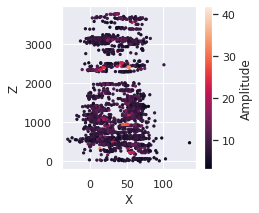

In [ ]:
# Inspect a single trial
idx = 0
plt.rcParams["figure.figsize"] = (3,3)
plt.rcParams.update({'font.size': 15})
plt.scatter(all_trials[idx][:,1], all_trials[idx][:,2], c=all_trials[idx][:,3], s=5),
plt.xlabel("X")
plt.ylabel("Z")
plt.colorbar(label="Amplitude");

In [ ]:
summarize(all_trials)
max_seq_len = 3580

number of trials: 286
spike sequence length range: 2134 ~ 3578
time range (sec): 0.000 ~ 1.500
x range:   -13.195 ~ 76.024
z range:   -5.847 ~ 3786.594
amp range:   4.112 ~ 35.244


In [ ]:
# Select spikes from a given brain region
min_x = -25; max_x = 125
min_z = 350; max_z = 450 

regional_trials = []
for n in range(n_trials):
    trial = data[(data[:,0] >= start_movement_times[n]-30003.0003*0.5) & (data[:,0] <= start_movement_times[n]+30003.0003),:]
    trial = trial[(trial[:,1] >= min_x) & (trial[:,1] <= max_x),:]
    trial = trial[(trial[:,2] >= min_z) & (trial[:,2] <= max_z),:]
    trial[:,0] = (trial[:,0] - trial[:,0].min()) / 30003.0003
    regional_trials.append(trial) 

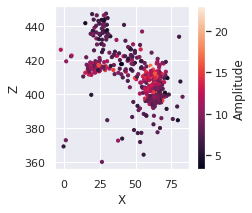

In [ ]:
# Inspect a single trial within a given region
idx = 0
plt.scatter(regional_trials[idx][:,1], regional_trials[idx][:,2], c=regional_trials[idx][:,3], s=10);
plt.xlabel("X");
plt.ylabel("Z");
plt.colorbar(label="Amplitude");

In [ ]:
# Experiment with shorter sequences
summarize(regional_trials)
# max_seq_len = 520

number of trials: 286
spike sequence length range: 111 ~ 518
time range (sec): 0.000 ~ 1.500
x range:   2.665 ~ 105.033
z range:   363.708 ~ 448.330
amp range:   3.888 ~ 16.334


Define Model

In [ ]:
class PositionalEncoding(nn.Module):
    """
    ref: https://github.com/harvardnlp/annotated-transformer/
    """
    def __init__(self, emb_dim, drop_out, max_len):
        super(PositionalEncoding, self).__init__()
        self.emb_dim = emb_dim
        self.dropout = nn.Dropout(p=drop_out)
        self.max_len = max_len
        
        if torch.cuda.is_available():
            self.device = torch.device('cuda:0')
        else:
            self.device = torch.device("cpu")

    def forward(self, x, t):
        # Compute the positional encodings in log space
        t = t.unsqueeze(2).to(device)
        pe = torch.zeros(x.size(0), self.max_len, self.emb_dim).to(self.device)
        div_term = torch.exp(torch.arange(0, self.emb_dim, 2).float() * (-math.log(10000.0) / self.emb_dim)).to(self.device)
        pe[:, :, 0::2] = torch.sin(t * div_term)
        pe[:, :, 1::2] = torch.cos(t * div_term)  
        self.register_buffer("pe", pe)

        x = x + self.pe.requires_grad_(False)
        return self.dropout(x)

In [ ]:
class Encoder(nn.Module):
    """
    Encode spike events to embeddings
    """
    def __init__(self, config, device):
        super().__init__()
        self.pos_encoder = PositionalEncoding(config.emb_dim, config.drop_out, 
                                              config.seq_len)
        encoder_layers = nn.TransformerEncoderLayer(config.emb_dim, config.num_head,
                                                    config.hid_dim, config.drop_out)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, config.n_trans_layers)
        self.seq_len = config.seq_len
        self.ninp = config.emb_dim
        self.encoder = nn.Linear(config.n_feature, config.emb_dim, bias=False)
        self.init_weights()
        self.device = device
        
    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)

    def encode(self, batch_seqs, batch_ts, batch_masks):
        attn_mask = None
        xs = self.encoder(batch_seqs) * math.sqrt(self.ninp)
        xs = self.pos_encoder(xs, batch_ts)    
        xs = self.transformer_encoder(src=xs, mask=attn_mask, src_key_padding_mask=batch_masks.transpose(1,0))
        return xs

In [ ]:
class Multi_Task_Encoder_Decoder(nn.Module):
    def __init__(self, config, device):
        super(Multi_Task_Encoder_Decoder, self).__init__()
        self.config = config
        self.emb_dim = config.emb_dim
        self.hid_dim = config.hid_dim
        self.device = device
        
        self.enc = Encoder(config, device)

        c_decoder_layers = []
        c_decoder_layers.append(nn.AvgPool2d((300, 1), stride=(100, 1)))
        c_decoder_layers.append(nn.Flatten(start_dim=1))
        c_decoder_layers.append(nn.BatchNorm1d(1056)) 
        c_decoder_layers.append(nn.Linear(1056, 128))
        c_decoder_layers.append(nn.ReLU())
        c_decoder_layers.append(nn.Dropout(config.drop_out))
        c_decoder_layers.append(nn.Linear(128, 2))

        s_decoder_layers = []
        s_decoder_layers.append(nn.AvgPool2d((300, 1), stride=(100, 1)))
        s_decoder_layers.append(nn.Flatten(start_dim=1))
        s_decoder_layers.append(nn.BatchNorm1d(1056)) 
        s_decoder_layers.append(nn.Linear(1056, 128))
        s_decoder_layers.append(nn.ReLU())
        s_decoder_layers.append(nn.Dropout(config.drop_out))
        s_decoder_layers.append(nn.Linear(128, 2))

        self.choice_decoder = nn.Sequential(*c_decoder_layers)
        self.stimuli_decoder = nn.Sequential(*s_decoder_layers)

        self.softmax = nn.Softmax(dim=1)
                
        self.optimizer = self.set_optimizer(config.opt, config.lr, config.momentum)
        self.to(device)


    def loss(self, batch_seqs, batch_ts, batch_masks, batch_choices, batch_stimuli):
        choice_preds, stimuli_preds = self(batch_seqs, batch_ts, batch_masks)    
        choice_loss = nn.CrossEntropyLoss()(choice_preds, batch_choices)
        stimuli_loss = nn.CrossEntropyLoss()(stimuli_preds, batch_stimuli)
        return choice_loss, stimuli_loss
   
    
    def forward(self, batch_seqs, batch_ts, batch_masks):        
        batch_embeds = self.enc.encode(batch_seqs, batch_ts, batch_masks)
        choice_preds = self.choice_decoder(batch_embeds)
        choice_preds = self.softmax(choice_preds)
        stimuli_preds = self.stimuli_decoder(batch_embeds)
        stimuli_preds = self.softmax(stimuli_preds)
        return choice_preds, stimuli_preds
  
    
    def set_optimizer(self, opt, lr, momentum):
        if opt == 'SGD':
            return torch.optim.SGD(self.parameters(), lr=lr, momentum=momentum, weight_decay=config.weight_decay) # L2-Regularization
        elif opt == 'Adam':
            return torch.optim.Adam(self.parameters(), lr=lr, weight_decay=config.weight_decay)

In [ ]:
m1 = nn.AvgPool2d((300, 1), stride=(100, 1))
input = torch.randn(config.batch, config.seq_len, config.emb_dim)
print(input.shape)
output = m1(input)
print(output.shape)
output.flatten(1).shape

torch.Size([32, 3580, 32])
torch.Size([32, 33, 32])


torch.Size([32, 1056])

In [ ]:
class AverageMeter(object):
    """
    Computes and stores the average and current value
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def eval_loss(model, test_loader, device):
    model.eval()
    choice_loss_meter = AverageMeter()
    choice_auc_meter = AverageMeter()
    choice_acc_meter = AverageMeter()
    stimuli_loss_meter = AverageMeter()
    stimuli_auc_meter = AverageMeter()
    stimuli_acc_meter = AverageMeter()
    
    for index, batch in enumerate(test_loader):
        batch_ts, batch_seqs, batch_masks, batch_choices, batch_stimuli = map(lambda x: cast(x, device), batch)
        choice_true = batch_choices.cpu().detach().numpy()
        stimuli_true = batch_stimuli.cpu().detach().numpy()
        choice_preds, stimuli_preds = model(batch_seqs, batch_ts, batch_masks)
        choice_preds, stimuli_preds = choice_preds.cpu().detach().numpy(), stimuli_preds.cpu().detach().numpy()
        choice_loss, stimuli_loss = model.loss(batch_seqs, batch_ts, batch_masks, batch_choices, batch_stimuli)
        choice_loss_meter.update(choice_loss.item())
        stimuli_loss_meter.update(stimuli_loss.item())
        auc = np.infty
        try:
            auc = roc_auc_score(choice_true, choice_preds)
        except ValueError as e:
            print('Only one class present in y_true. ROC AUC score is not defined in that case.')
        choice_auc_meter.update(auc)
        acc = accuracy_score(choice_true.argmax(1), choice_preds.argmax(1))
        choice_acc_meter.update(acc)

        auc = np.infty
        try:
            auc = roc_auc_score(stimuli_true, stimuli_preds)
        except ValueError as e:
            print('Only one class present in y_true. ROC AUC score is not defined in that case.')
        stimuli_auc_meter.update(auc)
        acc = accuracy_score(stimuli_true.argmax(1), stimuli_preds.argmax(1))
        stimuli_acc_meter.update(acc)
        
    return choice_loss_meter.avg, choice_auc_meter.avg, choice_acc_meter.avg, stimuli_loss_meter.avg, stimuli_auc_meter.avg, stimuli_acc_meter.avg

In [ ]:
def train(model, train_loader, val_loader, config, logger, device):
    scheduler = torch.optim.lr_scheduler.StepLR(model.optimizer, step_size=30, gamma=0.1)
    loss_meter = AverageMeter()

    train_losses = []
    val_losses = []
    for epoch in trange(config.epochs):
        loss_total = 0
        model.train()
        for index, batch in tenumerate(train_loader):
            batch_ts, batch_seqs, batch_masks, batch_choices, batch_stimuli = map(lambda x: cast(x, device), batch)

            model.optimizer.zero_grad()
            choice_loss, stimuli_loss = model.loss(batch_seqs, batch_ts, batch_masks, batch_choices, batch_stimuli)
            total_loss = choice_loss + stimuli_loss

            if torch.isnan(total_loss):
                print("Numerical error, quiting...")
                return model

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=config.clip)
            model.optimizer.step()

            loss_meter.update(total_loss.item())

        scheduler.step()

        logger.info("Epoch {} | "
                    "Total loss: {:5f}".format(
            epoch, loss_meter.avg
        ))
        if (epoch + 1) % config.eval_epoch == 0:
            c_loss, c_auc, c_acc, s_loss, s_auc, s_acc = eval_loss(model, train_loader, device)
            logger.info("Train choice loss {:3f} choice AUC {:3f} choice Acc {:3f} | stimuli loss {:3f} stimuli AUC {:3f} stimuli Acc {:3f}".format(c_loss, c_auc, c_acc, s_loss, s_auc, s_acc))
            train_losses.append([[c_loss], [c_auc], [c_acc], [s_loss], [s_auc], [s_acc]])
            c_loss, c_auc, c_acc, s_loss, s_auc, s_acc = eval_loss(model, val_loader, device)
            logger.info("Val choice loss {:3f} choice AUC {:3f} choice Acc {:3f} | stimuli loss {:3f} stimuli AUC {:3f} stimuli Acc {:3f}".format(c_loss, c_auc, c_acc, s_loss, s_auc, s_acc))
            val_losses.append([[c_loss], [c_auc], [c_acc], [s_loss], [s_auc], [s_acc]])

    print("Training done!")
    train_losses = np.asarray(train_losses) 
    val_losses = np.asarray(val_losses)
    return train_losses, val_losses

In [ ]:
def reset_weights(model):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

Model Training

In [ ]:
max_seq_len

3580

In [ ]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

config = Namespace(hid_dim=32, emb_dim=32, n_feature=4,
                   lr=1e-4, momentum=0.9, weight_decay=1e-6,
                   epochs=50, batch=32, opt='Adam', 
                   seq_len=max_seq_len, eval_epoch=1,
                   drop_out=0.1, num_head=8,
                   n_trans_layers=3, clip=1e7)

In [ ]:
# Prepare logger
logger = logging.getLogger('batch{}'.format(config.batch))
logger.setLevel(logging.DEBUG)
hdlr = logging.FileHandler('batch{}.log'.format(config.batch))
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
hdlr.setFormatter(formatter)
logger.addHandler(hdlr)

ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
ch.setFormatter(formatter)
logger.addHandler(ch)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
class SpatioTemporalDataset(torch.utils.data.Dataset):

    def __init__(self, train_set, test_set, train, train_choices, test_choices, train_stimuli, test_stimuli):
        self.S_mean, self.S_std = self._standardize(train_set)

        S_mean_ = torch.cat([torch.zeros(1, 1).to(self.S_mean), self.S_mean], dim=1)
        S_std_ = torch.cat([torch.ones(1, 1).to(self.S_std), self.S_std], dim=1)
        self.dataset = [(torch.tensor(seq) - S_mean_) / S_std_ for seq in (train_set if train else test_set)]
        
        self.choices = [torch.tensor(label) for label in (train_choices if train else test_choices)]
        self.stimuli = [torch.tensor(label) for label in (train_stimuli if train else test_stimuli)]

    def __len__(self):
        return len(self.dataset)

    def _standardize(self, dataset):
        dataset = [torch.tensor(seq) for seq in dataset]
        full = torch.cat(dataset, dim=0)
        S = full[:, 1:]
        S_mean = S.mean(0, keepdims=True)
        S_std = S.std(0, keepdims=True)
        return S_mean, S_std

    def unstandardize(self, spatial_locations):
        return spatial_locations * self.S_std + self.S_mean

    def ordered_indices(self):
        lengths = np.array([seq.shape[0] for seq in self.dataset])
        indices = np.argsort(lengths)
        return indices, lengths[indices]

    def __getitem__(self, index):
        return self.dataset[index], self.choices[index], self.stimuli[index]

In [ ]:
class NeuralData(SpatioTemporalDataset):
        def __init__(self, split="train", train_ids=None, val_ids=None, test_ids=None):
            assert split in ["train", "val", "test"]
            self.split = split
            data_splits = {"train": train_ids, "val": val_ids, "test": test_ids}
            train_set = [all_trials[idx] for idx in train_ids]
            split_set = [all_trials[idx] for idx in data_splits[split]]
            train_choices = [choices[idx] for idx in train_ids]
            split_choices = [choices[idx] for idx in data_splits[split]]
            train_stimuli = [stimuli[idx] for idx in train_ids]
            split_stimuli = [stimuli [idx] for idx in data_splits[split]]
            super().__init__(train_set, split_set, split == "train", train_choices, split_choices, train_stimuli, split_stimuli)

        def extra_repr(self):
            return f"Split: {self.split}"

In [ ]:
def spatiotemporal_events_collate_fn(dataset):
    """Input is a list of tensors with shape (T, 1 + D)
        where T may be different for each tensor.
    Returns:
        event_times: (N, max_T)
        spatial_locations: (N, max_T, D)
        mask: (N, max_T)
    """
    if len(dataset) == 0:
        # Dummy batch, sometimes this occurs when using multi-GPU.
        return torch.zeros(1, 1), torch.zeros(1, 1, 2), torch.zeros(1, 1)
    seqs = [x[0] for x in dataset]
    choices = [x[1] for x in dataset]
    stimuli = [x[2] for x in dataset]
    dim = seqs[0].shape[1]
    lengths = [seq.shape[0] for seq in seqs]
    max_len = max_seq_len
    padded_seqs = [torch.cat([s, torch.zeros(max_len - s.shape[0], dim).to(s)], 0) if s.shape[0] != max_len else s for s in seqs]
    seqs = torch.stack(padded_seqs, dim=0)
    event_times = seqs[:, :, 0]
    spatial_locations = seqs[:, :, 1:]
    mask = torch.stack([torch.cat([torch.ones(seq_len), torch.zeros(max_len - seq_len)], dim=0) for seq_len in lengths])
    choices = torch.stack(choices, dim=0)
    stimuli = torch.stack(stimuli, dim=0)
    return event_times, spatial_locations, mask, choices, stimuli

In [ ]:
def cast(tensor, device):
    return tensor.float().to(device)

In [ ]:
trial_ids = np.arange(286)
random.shuffle(trial_ids)

In [ ]:
train_ids = trial_ids[:228]
val_ids = trial_ids[228:257]
test_ids = trial_ids[257:]

train_set = NeuralData(split="train", train_ids=train_ids, val_ids=val_ids, test_ids=test_ids)
val_set = NeuralData(split="val", train_ids=train_ids, val_ids=val_ids, test_ids=test_ids)
test_set = NeuralData(split="test", train_ids=train_ids, val_ids=val_ids, test_ids=test_ids)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=32,
    shuffle=True,
    collate_fn=spatiotemporal_events_collate_fn,
)
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=32,
    shuffle=False,
    collate_fn=spatiotemporal_events_collate_fn,
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=32,
    shuffle=False,
    collate_fn=spatiotemporal_events_collate_fn,
)

In [ ]:
model = Multi_Task_Encoder_Decoder(config, device)
model.apply(reset_weights)

Reset trainable parameters of layer = NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = LayerNorm((32,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = LayerNorm((32,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = LayerNorm((32,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = LayerNorm((32,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = NonDynamically

Multi_Task_Encoder_Decoder(
  (enc): Encoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
          )
          (linear1): Linear(in_features=32, out_features=32, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=32, out_features=32, bias=True)
          (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_f

In [ ]:
sum([param.nelement() for param in model.parameters()])

494532

In [ ]:
train_losses, val_losses = train(model, train_loader, val_loader, config, logger, device)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:12:47,175 INFO Epoch 0 | Total loss: 1.343970
2022-07-20 22:12:47,175 INFO Epoch 0 | Total loss: 1.343970
2022-07-20 22:12:47,175 INFO Epoch 0 | Total loss: 1.343970
INFO:batch32:Epoch 0 | Total loss: 1.343970
2022-07-20 22:12:47,496 INFO Train choice loss 0.688000 choice AUC 0.812623 choice Acc 0.484375 | stimuli loss 0.622862 stimuli AUC 0.957302 stimuli Acc 0.875000
2022-07-20 22:12:47,496 INFO Train choice loss 0.688000 choice AUC 0.812623 choice Acc 0.484375 | stimuli loss 0.622862 stimuli AUC 0.957302 stimuli Acc 0.875000
2022-07-20 22:12:47,496 INFO Train choice loss 0.688000 choice AUC 0.812623 choice Acc 0.484375 | stimuli loss 0.622862 stimuli AUC 0.957302 stimuli Acc 0.875000
INFO:batch32:Train choice loss 0.688000 choice AUC 0.812623 choice Acc 0.484375 | stimuli loss 0.622862 stimuli AUC 0.957302 stimuli Acc 0.875000
2022-07-20 22:12:47,556 INFO Val choice loss 0.697539 choice AUC 0.739130 choice Acc 0.413793 | stimuli loss 0.634973 stimuli AUC 0.825000 stimu

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:12:47,979 INFO Epoch 1 | Total loss: 1.235086
2022-07-20 22:12:47,979 INFO Epoch 1 | Total loss: 1.235086
2022-07-20 22:12:47,979 INFO Epoch 1 | Total loss: 1.235086
INFO:batch32:Epoch 1 | Total loss: 1.235086
2022-07-20 22:12:48,294 INFO Train choice loss 0.649474 choice AUC 0.877889 choice Acc 0.664062 | stimuli loss 0.565561 stimuli AUC inf stimuli Acc 0.886719
2022-07-20 22:12:48,294 INFO Train choice loss 0.649474 choice AUC 0.877889 choice Acc 0.664062 | stimuli loss 0.565561 stimuli AUC inf stimuli Acc 0.886719
2022-07-20 22:12:48,294 INFO Train choice loss 0.649474 choice AUC 0.877889 choice Acc 0.664062 | stimuli loss 0.565561 stimuli AUC inf stimuli Acc 0.886719
INFO:batch32:Train choice loss 0.649474 choice AUC 0.877889 choice Acc 0.664062 | stimuli loss 0.565561 stimuli AUC inf stimuli Acc 0.886719
2022-07-20 22:12:48,354 INFO Val choice loss 0.653620 choice AUC 0.804348 choice Acc 0.620690 | stimuli loss 0.589143 stimuli AUC 0.858333 stimuli Acc 0.862069
2022

Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:12:48,797 INFO Epoch 2 | Total loss: 1.167216
2022-07-20 22:12:48,797 INFO Epoch 2 | Total loss: 1.167216
2022-07-20 22:12:48,797 INFO Epoch 2 | Total loss: 1.167216
INFO:batch32:Epoch 2 | Total loss: 1.167216
2022-07-20 22:12:49,119 INFO Train choice loss 0.602482 choice AUC 0.882392 choice Acc 0.789062 | stimuli loss 0.512211 stimuli AUC 0.976457 stimuli Acc 0.906250
2022-07-20 22:12:49,119 INFO Train choice loss 0.602482 choice AUC 0.882392 choice Acc 0.789062 | stimuli loss 0.512211 stimuli AUC 0.976457 stimuli Acc 0.906250
2022-07-20 22:12:49,119 INFO Train choice loss 0.602482 choice AUC 0.882392 choice Acc 0.789062 | stimuli loss 0.512211 stimuli AUC 0.976457 stimuli Acc 0.906250
INFO:batch32:Train choice loss 0.602482 choice AUC 0.882392 choice Acc 0.789062 | stimuli loss 0.512211 stimuli AUC 0.976457 stimuli Acc 0.906250
2022-07-20 22:12:49,177 INFO Val choice loss 0.601216 choice AUC 0.869565 choice Acc 0.827586 | stimuli loss 0.541933 stimuli AUC 0.858333 stimu

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:12:49,596 INFO Epoch 3 | Total loss: 1.115676
2022-07-20 22:12:49,596 INFO Epoch 3 | Total loss: 1.115676
2022-07-20 22:12:49,596 INFO Epoch 3 | Total loss: 1.115676
INFO:batch32:Epoch 3 | Total loss: 1.115676
2022-07-20 22:12:49,914 INFO Train choice loss 0.568032 choice AUC inf choice Acc 0.800781 | stimuli loss 0.454851 stimuli AUC inf stimuli Acc 0.937500
2022-07-20 22:12:49,914 INFO Train choice loss 0.568032 choice AUC inf choice Acc 0.800781 | stimuli loss 0.454851 stimuli AUC inf stimuli Acc 0.937500
2022-07-20 22:12:49,914 INFO Train choice loss 0.568032 choice AUC inf choice Acc 0.800781 | stimuli loss 0.454851 stimuli AUC inf stimuli Acc 0.937500
INFO:batch32:Train choice loss 0.568032 choice AUC inf choice Acc 0.800781 | stimuli loss 0.454851 stimuli AUC inf stimuli Acc 0.937500
2022-07-20 22:12:49,973 INFO Val choice loss 0.551592 choice AUC 0.876812 choice Acc 0.758621 | stimuli loss 0.503847 stimuli AUC 0.866667 stimuli Acc 0.862069
2022-07-20 22:12:49,973 

Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:12:50,411 INFO Epoch 4 | Total loss: 1.082095
2022-07-20 22:12:50,411 INFO Epoch 4 | Total loss: 1.082095
2022-07-20 22:12:50,411 INFO Epoch 4 | Total loss: 1.082095
INFO:batch32:Epoch 4 | Total loss: 1.082095
2022-07-20 22:12:50,731 INFO Train choice loss 0.520611 choice AUC 0.919504 choice Acc 0.871094 | stimuli loss 0.413306 stimuli AUC inf stimuli Acc 0.949219
2022-07-20 22:12:50,731 INFO Train choice loss 0.520611 choice AUC 0.919504 choice Acc 0.871094 | stimuli loss 0.413306 stimuli AUC inf stimuli Acc 0.949219
2022-07-20 22:12:50,731 INFO Train choice loss 0.520611 choice AUC 0.919504 choice Acc 0.871094 | stimuli loss 0.413306 stimuli AUC inf stimuli Acc 0.949219
INFO:batch32:Train choice loss 0.520611 choice AUC 0.919504 choice Acc 0.871094 | stimuli loss 0.413306 stimuli AUC inf stimuli Acc 0.949219
2022-07-20 22:12:50,791 INFO Val choice loss 0.515558 choice AUC 0.884058 choice Acc 0.862069 | stimuli loss 0.475033 stimuli AUC 0.908333 stimuli Acc 0.862069
2022

Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:12:51,212 INFO Epoch 5 | Total loss: 1.049602
2022-07-20 22:12:51,212 INFO Epoch 5 | Total loss: 1.049602
2022-07-20 22:12:51,212 INFO Epoch 5 | Total loss: 1.049602
INFO:batch32:Epoch 5 | Total loss: 1.049602
2022-07-20 22:12:51,529 INFO Train choice loss 0.476432 choice AUC 0.918776 choice Acc 0.914062 | stimuli loss 0.390857 stimuli AUC inf stimuli Acc 0.957031
2022-07-20 22:12:51,529 INFO Train choice loss 0.476432 choice AUC 0.918776 choice Acc 0.914062 | stimuli loss 0.390857 stimuli AUC inf stimuli Acc 0.957031
2022-07-20 22:12:51,529 INFO Train choice loss 0.476432 choice AUC 0.918776 choice Acc 0.914062 | stimuli loss 0.390857 stimuli AUC inf stimuli Acc 0.957031
INFO:batch32:Train choice loss 0.476432 choice AUC 0.918776 choice Acc 0.914062 | stimuli loss 0.390857 stimuli AUC inf stimuli Acc 0.957031
2022-07-20 22:12:51,585 INFO Val choice loss 0.493575 choice AUC 0.898551 choice Acc 0.862069 | stimuli loss 0.451964 stimuli AUC 0.925000 stimuli Acc 0.862069
2022

Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:12:52,007 INFO Epoch 6 | Total loss: 1.023883
2022-07-20 22:12:52,007 INFO Epoch 6 | Total loss: 1.023883
2022-07-20 22:12:52,007 INFO Epoch 6 | Total loss: 1.023883
INFO:batch32:Epoch 6 | Total loss: 1.023883
2022-07-20 22:12:52,335 INFO Train choice loss 0.460070 choice AUC inf choice Acc 0.882812 | stimuli loss 0.372733 stimuli AUC 0.990746 stimuli Acc 0.960938
2022-07-20 22:12:52,335 INFO Train choice loss 0.460070 choice AUC inf choice Acc 0.882812 | stimuli loss 0.372733 stimuli AUC 0.990746 stimuli Acc 0.960938
2022-07-20 22:12:52,335 INFO Train choice loss 0.460070 choice AUC inf choice Acc 0.882812 | stimuli loss 0.372733 stimuli AUC 0.990746 stimuli Acc 0.960938
INFO:batch32:Train choice loss 0.460070 choice AUC inf choice Acc 0.882812 | stimuli loss 0.372733 stimuli AUC 0.990746 stimuli Acc 0.960938
2022-07-20 22:12:52,402 INFO Val choice loss 0.475808 choice AUC 0.927536 choice Acc 0.862069 | stimuli loss 0.439994 stimuli AUC 0.950000 stimuli Acc 0.862069
2022

Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:12:52,838 INFO Epoch 7 | Total loss: 1.001391
2022-07-20 22:12:52,838 INFO Epoch 7 | Total loss: 1.001391
2022-07-20 22:12:52,838 INFO Epoch 7 | Total loss: 1.001391
INFO:batch32:Epoch 7 | Total loss: 1.001391
2022-07-20 22:12:53,150 INFO Train choice loss 0.449854 choice AUC 0.947667 choice Acc 0.894531 | stimuli loss 0.371667 stimuli AUC 0.990197 stimuli Acc 0.964844
2022-07-20 22:12:53,150 INFO Train choice loss 0.449854 choice AUC 0.947667 choice Acc 0.894531 | stimuli loss 0.371667 stimuli AUC 0.990197 stimuli Acc 0.964844
2022-07-20 22:12:53,150 INFO Train choice loss 0.449854 choice AUC 0.947667 choice Acc 0.894531 | stimuli loss 0.371667 stimuli AUC 0.990197 stimuli Acc 0.964844
INFO:batch32:Train choice loss 0.449854 choice AUC 0.947667 choice Acc 0.894531 | stimuli loss 0.371667 stimuli AUC 0.990197 stimuli Acc 0.964844
2022-07-20 22:12:53,205 INFO Val choice loss 0.468995 choice AUC 0.920290 choice Acc 0.862069 | stimuli loss 0.431737 stimuli AUC 0.958333 stimu

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:12:53,649 INFO Epoch 8 | Total loss: 0.984912
2022-07-20 22:12:53,649 INFO Epoch 8 | Total loss: 0.984912
2022-07-20 22:12:53,649 INFO Epoch 8 | Total loss: 0.984912
INFO:batch32:Epoch 8 | Total loss: 0.984912
2022-07-20 22:12:53,970 INFO Train choice loss 0.449748 choice AUC 0.942017 choice Acc 0.898438 | stimuli loss 0.359186 stimuli AUC inf stimuli Acc 0.960938
2022-07-20 22:12:53,970 INFO Train choice loss 0.449748 choice AUC 0.942017 choice Acc 0.898438 | stimuli loss 0.359186 stimuli AUC inf stimuli Acc 0.960938
2022-07-20 22:12:53,970 INFO Train choice loss 0.449748 choice AUC 0.942017 choice Acc 0.898438 | stimuli loss 0.359186 stimuli AUC inf stimuli Acc 0.960938
INFO:batch32:Train choice loss 0.449748 choice AUC 0.942017 choice Acc 0.898438 | stimuli loss 0.359186 stimuli AUC inf stimuli Acc 0.960938
2022-07-20 22:12:54,032 INFO Val choice loss 0.465520 choice AUC 0.927536 choice Acc 0.862069 | stimuli loss 0.428611 stimuli AUC 0.958333 stimuli Acc 0.862069
2022

Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:12:54,476 INFO Epoch 9 | Total loss: 0.972518
2022-07-20 22:12:54,476 INFO Epoch 9 | Total loss: 0.972518
2022-07-20 22:12:54,476 INFO Epoch 9 | Total loss: 0.972518
INFO:batch32:Epoch 9 | Total loss: 0.972518
2022-07-20 22:12:54,798 INFO Train choice loss 0.433791 choice AUC inf choice Acc 0.929688 | stimuli loss 0.356916 stimuli AUC inf stimuli Acc 0.964844
2022-07-20 22:12:54,798 INFO Train choice loss 0.433791 choice AUC inf choice Acc 0.929688 | stimuli loss 0.356916 stimuli AUC inf stimuli Acc 0.964844
2022-07-20 22:12:54,798 INFO Train choice loss 0.433791 choice AUC inf choice Acc 0.929688 | stimuli loss 0.356916 stimuli AUC inf stimuli Acc 0.964844
INFO:batch32:Train choice loss 0.433791 choice AUC inf choice Acc 0.929688 | stimuli loss 0.356916 stimuli AUC inf stimuli Acc 0.964844
2022-07-20 22:12:54,856 INFO Val choice loss 0.464865 choice AUC 0.934783 choice Acc 0.862069 | stimuli loss 0.421321 stimuli AUC 0.966667 stimuli Acc 0.862069
2022-07-20 22:12:54,856 

Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:12:55,291 INFO Epoch 10 | Total loss: 0.959980
2022-07-20 22:12:55,291 INFO Epoch 10 | Total loss: 0.959980
2022-07-20 22:12:55,291 INFO Epoch 10 | Total loss: 0.959980
INFO:batch32:Epoch 10 | Total loss: 0.959980
2022-07-20 22:12:55,618 INFO Train choice loss 0.414298 choice AUC inf choice Acc 0.921875 | stimuli loss 0.355523 stimuli AUC 0.993008 stimuli Acc 0.960938
2022-07-20 22:12:55,618 INFO Train choice loss 0.414298 choice AUC inf choice Acc 0.921875 | stimuli loss 0.355523 stimuli AUC 0.993008 stimuli Acc 0.960938
2022-07-20 22:12:55,618 INFO Train choice loss 0.414298 choice AUC inf choice Acc 0.921875 | stimuli loss 0.355523 stimuli AUC 0.993008 stimuli Acc 0.960938
INFO:batch32:Train choice loss 0.414298 choice AUC inf choice Acc 0.921875 | stimuli loss 0.355523 stimuli AUC 0.993008 stimuli Acc 0.960938
2022-07-20 22:12:55,677 INFO Val choice loss 0.460149 choice AUC 0.920290 choice Acc 0.862069 | stimuli loss 0.397849 stimuli AUC 0.966667 stimuli Acc 0.896552


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:12:56,104 INFO Epoch 11 | Total loss: 0.946119
2022-07-20 22:12:56,104 INFO Epoch 11 | Total loss: 0.946119
2022-07-20 22:12:56,104 INFO Epoch 11 | Total loss: 0.946119
INFO:batch32:Epoch 11 | Total loss: 0.946119
2022-07-20 22:12:56,431 INFO Train choice loss 0.432137 choice AUC inf choice Acc 0.933594 | stimuli loss 0.376881 stimuli AUC 1.000000 stimuli Acc 0.933594
2022-07-20 22:12:56,431 INFO Train choice loss 0.432137 choice AUC inf choice Acc 0.933594 | stimuli loss 0.376881 stimuli AUC 1.000000 stimuli Acc 0.933594
2022-07-20 22:12:56,431 INFO Train choice loss 0.432137 choice AUC inf choice Acc 0.933594 | stimuli loss 0.376881 stimuli AUC 1.000000 stimuli Acc 0.933594
INFO:batch32:Train choice loss 0.432137 choice AUC inf choice Acc 0.933594 | stimuli loss 0.376881 stimuli AUC 1.000000 stimuli Acc 0.933594
2022-07-20 22:12:56,492 INFO Val choice loss 0.460568 choice AUC 0.913043 choice Acc 0.862069 | stimuli loss 0.393456 stimuli AUC 0.966667 stimuli Acc 0.931034


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:12:56,923 INFO Epoch 12 | Total loss: 0.933620
2022-07-20 22:12:56,923 INFO Epoch 12 | Total loss: 0.933620
2022-07-20 22:12:56,923 INFO Epoch 12 | Total loss: 0.933620
INFO:batch32:Epoch 12 | Total loss: 0.933620
2022-07-20 22:12:57,259 INFO Train choice loss 0.422669 choice AUC 0.969062 choice Acc 0.906250 | stimuli loss 0.354056 stimuli AUC 0.997580 stimuli Acc 0.960938
2022-07-20 22:12:57,259 INFO Train choice loss 0.422669 choice AUC 0.969062 choice Acc 0.906250 | stimuli loss 0.354056 stimuli AUC 0.997580 stimuli Acc 0.960938
2022-07-20 22:12:57,259 INFO Train choice loss 0.422669 choice AUC 0.969062 choice Acc 0.906250 | stimuli loss 0.354056 stimuli AUC 0.997580 stimuli Acc 0.960938
INFO:batch32:Train choice loss 0.422669 choice AUC 0.969062 choice Acc 0.906250 | stimuli loss 0.354056 stimuli AUC 0.997580 stimuli Acc 0.960938
2022-07-20 22:12:57,318 INFO Val choice loss 0.459116 choice AUC 0.927536 choice Acc 0.862069 | stimuli loss 0.389553 stimuli AUC 0.966667 s

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:12:57,762 INFO Epoch 13 | Total loss: 0.925652
2022-07-20 22:12:57,762 INFO Epoch 13 | Total loss: 0.925652
2022-07-20 22:12:57,762 INFO Epoch 13 | Total loss: 0.925652
INFO:batch32:Epoch 13 | Total loss: 0.925652
2022-07-20 22:12:58,087 INFO Train choice loss 0.403843 choice AUC 0.969117 choice Acc 0.937500 | stimuli loss 0.371522 stimuli AUC 0.995584 stimuli Acc 0.933594
2022-07-20 22:12:58,087 INFO Train choice loss 0.403843 choice AUC 0.969117 choice Acc 0.937500 | stimuli loss 0.371522 stimuli AUC 0.995584 stimuli Acc 0.933594
2022-07-20 22:12:58,087 INFO Train choice loss 0.403843 choice AUC 0.969117 choice Acc 0.937500 | stimuli loss 0.371522 stimuli AUC 0.995584 stimuli Acc 0.933594
INFO:batch32:Train choice loss 0.403843 choice AUC 0.969117 choice Acc 0.937500 | stimuli loss 0.371522 stimuli AUC 0.995584 stimuli Acc 0.933594
2022-07-20 22:12:58,146 INFO Val choice loss 0.459078 choice AUC 0.934783 choice Acc 0.862069 | stimuli loss 0.393587 stimuli AUC 0.975000 s

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:12:58,589 INFO Epoch 14 | Total loss: 0.915564
2022-07-20 22:12:58,589 INFO Epoch 14 | Total loss: 0.915564
2022-07-20 22:12:58,589 INFO Epoch 14 | Total loss: 0.915564
INFO:batch32:Epoch 14 | Total loss: 0.915564
2022-07-20 22:12:58,919 INFO Train choice loss 0.401122 choice AUC 0.958331 choice Acc 0.941406 | stimuli loss 0.351920 stimuli AUC 0.996314 stimuli Acc 0.960938
2022-07-20 22:12:58,919 INFO Train choice loss 0.401122 choice AUC 0.958331 choice Acc 0.941406 | stimuli loss 0.351920 stimuli AUC 0.996314 stimuli Acc 0.960938
2022-07-20 22:12:58,919 INFO Train choice loss 0.401122 choice AUC 0.958331 choice Acc 0.941406 | stimuli loss 0.351920 stimuli AUC 0.996314 stimuli Acc 0.960938
INFO:batch32:Train choice loss 0.401122 choice AUC 0.958331 choice Acc 0.941406 | stimuli loss 0.351920 stimuli AUC 0.996314 stimuli Acc 0.960938
2022-07-20 22:12:58,976 INFO Val choice loss 0.458285 choice AUC 0.927536 choice Acc 0.862069 | stimuli loss 0.378105 stimuli AUC 0.975000 s

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:12:59,417 INFO Epoch 15 | Total loss: 0.905402
2022-07-20 22:12:59,417 INFO Epoch 15 | Total loss: 0.905402
2022-07-20 22:12:59,417 INFO Epoch 15 | Total loss: 0.905402
INFO:batch32:Epoch 15 | Total loss: 0.905402
2022-07-20 22:12:59,746 INFO Train choice loss 0.393880 choice AUC 0.962018 choice Acc 0.945312 | stimuli loss 0.349473 stimuli AUC 0.998571 stimuli Acc 0.964844
2022-07-20 22:12:59,746 INFO Train choice loss 0.393880 choice AUC 0.962018 choice Acc 0.945312 | stimuli loss 0.349473 stimuli AUC 0.998571 stimuli Acc 0.964844
2022-07-20 22:12:59,746 INFO Train choice loss 0.393880 choice AUC 0.962018 choice Acc 0.945312 | stimuli loss 0.349473 stimuli AUC 0.998571 stimuli Acc 0.964844
INFO:batch32:Train choice loss 0.393880 choice AUC 0.962018 choice Acc 0.945312 | stimuli loss 0.349473 stimuli AUC 0.998571 stimuli Acc 0.964844
2022-07-20 22:12:59,804 INFO Val choice loss 0.458320 choice AUC 0.927536 choice Acc 0.862069 | stimuli loss 0.378316 stimuli AUC 0.975000 s

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:00,240 INFO Epoch 16 | Total loss: 0.897135
2022-07-20 22:13:00,240 INFO Epoch 16 | Total loss: 0.897135
2022-07-20 22:13:00,240 INFO Epoch 16 | Total loss: 0.897135
INFO:batch32:Epoch 16 | Total loss: 0.897135
2022-07-20 22:13:00,567 INFO Train choice loss 0.410931 choice AUC 0.971158 choice Acc 0.945312 | stimuli loss 0.372990 stimuli AUC 0.998988 stimuli Acc 0.937500
2022-07-20 22:13:00,567 INFO Train choice loss 0.410931 choice AUC 0.971158 choice Acc 0.945312 | stimuli loss 0.372990 stimuli AUC 0.998988 stimuli Acc 0.937500
2022-07-20 22:13:00,567 INFO Train choice loss 0.410931 choice AUC 0.971158 choice Acc 0.945312 | stimuli loss 0.372990 stimuli AUC 0.998988 stimuli Acc 0.937500
INFO:batch32:Train choice loss 0.410931 choice AUC 0.971158 choice Acc 0.945312 | stimuli loss 0.372990 stimuli AUC 0.998988 stimuli Acc 0.937500
2022-07-20 22:13:00,628 INFO Val choice loss 0.458851 choice AUC 0.934783 choice Acc 0.827586 | stimuli loss 0.382034 stimuli AUC 0.975000 s

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:01,088 INFO Epoch 17 | Total loss: 0.892582
2022-07-20 22:13:01,088 INFO Epoch 17 | Total loss: 0.892582
2022-07-20 22:13:01,088 INFO Epoch 17 | Total loss: 0.892582
INFO:batch32:Epoch 17 | Total loss: 0.892582
2022-07-20 22:13:01,415 INFO Train choice loss 0.421447 choice AUC 0.977603 choice Acc 0.894531 | stimuli loss 0.349517 stimuli AUC 0.996314 stimuli Acc 0.960938
2022-07-20 22:13:01,415 INFO Train choice loss 0.421447 choice AUC 0.977603 choice Acc 0.894531 | stimuli loss 0.349517 stimuli AUC 0.996314 stimuli Acc 0.960938
2022-07-20 22:13:01,415 INFO Train choice loss 0.421447 choice AUC 0.977603 choice Acc 0.894531 | stimuli loss 0.349517 stimuli AUC 0.996314 stimuli Acc 0.960938
INFO:batch32:Train choice loss 0.421447 choice AUC 0.977603 choice Acc 0.894531 | stimuli loss 0.349517 stimuli AUC 0.996314 stimuli Acc 0.960938
2022-07-20 22:13:01,474 INFO Val choice loss 0.453754 choice AUC 0.942029 choice Acc 0.827586 | stimuli loss 0.375744 stimuli AUC 0.975000 s

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:02,159 INFO Epoch 18 | Total loss: 0.884983
2022-07-20 22:13:02,159 INFO Epoch 18 | Total loss: 0.884983
2022-07-20 22:13:02,159 INFO Epoch 18 | Total loss: 0.884983
INFO:batch32:Epoch 18 | Total loss: 0.884983
2022-07-20 22:13:02,790 INFO Train choice loss 0.388384 choice AUC 0.972180 choice Acc 0.953125 | stimuli loss 0.347077 stimuli AUC 0.999074 stimuli Acc 0.964844
2022-07-20 22:13:02,790 INFO Train choice loss 0.388384 choice AUC 0.972180 choice Acc 0.953125 | stimuli loss 0.347077 stimuli AUC 0.999074 stimuli Acc 0.964844
2022-07-20 22:13:02,790 INFO Train choice loss 0.388384 choice AUC 0.972180 choice Acc 0.953125 | stimuli loss 0.347077 stimuli AUC 0.999074 stimuli Acc 0.964844
INFO:batch32:Train choice loss 0.388384 choice AUC 0.972180 choice Acc 0.953125 | stimuli loss 0.347077 stimuli AUC 0.999074 stimuli Acc 0.964844
2022-07-20 22:13:02,846 INFO Val choice loss 0.457075 choice AUC 0.920290 choice Acc 0.862069 | stimuli loss 0.379858 stimuli AUC 0.975000 s

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:03,289 INFO Epoch 19 | Total loss: 0.878847
2022-07-20 22:13:03,289 INFO Epoch 19 | Total loss: 0.878847
2022-07-20 22:13:03,289 INFO Epoch 19 | Total loss: 0.878847
INFO:batch32:Epoch 19 | Total loss: 0.878847
2022-07-20 22:13:03,608 INFO Train choice loss 0.385460 choice AUC 0.974081 choice Acc 0.945312 | stimuli loss 0.342776 stimuli AUC inf stimuli Acc 0.972656
2022-07-20 22:13:03,608 INFO Train choice loss 0.385460 choice AUC 0.974081 choice Acc 0.945312 | stimuli loss 0.342776 stimuli AUC inf stimuli Acc 0.972656
2022-07-20 22:13:03,608 INFO Train choice loss 0.385460 choice AUC 0.974081 choice Acc 0.945312 | stimuli loss 0.342776 stimuli AUC inf stimuli Acc 0.972656
INFO:batch32:Train choice loss 0.385460 choice AUC 0.974081 choice Acc 0.945312 | stimuli loss 0.342776 stimuli AUC inf stimuli Acc 0.972656
2022-07-20 22:13:03,673 INFO Val choice loss 0.465794 choice AUC 0.927536 choice Acc 0.862069 | stimuli loss 0.391605 stimuli AUC 0.975000 stimuli Acc 0.896552


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:04,114 INFO Epoch 20 | Total loss: 0.872852
2022-07-20 22:13:04,114 INFO Epoch 20 | Total loss: 0.872852
2022-07-20 22:13:04,114 INFO Epoch 20 | Total loss: 0.872852
INFO:batch32:Epoch 20 | Total loss: 0.872852
2022-07-20 22:13:04,447 INFO Train choice loss 0.378980 choice AUC 0.975961 choice Acc 0.957031 | stimuli loss 0.346507 stimuli AUC inf stimuli Acc 0.972656
2022-07-20 22:13:04,447 INFO Train choice loss 0.378980 choice AUC 0.975961 choice Acc 0.957031 | stimuli loss 0.346507 stimuli AUC inf stimuli Acc 0.972656
2022-07-20 22:13:04,447 INFO Train choice loss 0.378980 choice AUC 0.975961 choice Acc 0.957031 | stimuli loss 0.346507 stimuli AUC inf stimuli Acc 0.972656
INFO:batch32:Train choice loss 0.378980 choice AUC 0.975961 choice Acc 0.957031 | stimuli loss 0.346507 stimuli AUC inf stimuli Acc 0.972656
2022-07-20 22:13:04,509 INFO Val choice loss 0.462162 choice AUC 0.920290 choice Acc 0.862069 | stimuli loss 0.377804 stimuli AUC 0.975000 stimuli Acc 0.931034


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:04,973 INFO Epoch 21 | Total loss: 0.868834
2022-07-20 22:13:04,973 INFO Epoch 21 | Total loss: 0.868834
2022-07-20 22:13:04,973 INFO Epoch 21 | Total loss: 0.868834
INFO:batch32:Epoch 21 | Total loss: 0.868834
2022-07-20 22:13:05,297 INFO Train choice loss 0.397660 choice AUC inf choice Acc 0.929688 | stimuli loss 0.357446 stimuli AUC 1.000000 stimuli Acc 0.945312
2022-07-20 22:13:05,297 INFO Train choice loss 0.397660 choice AUC inf choice Acc 0.929688 | stimuli loss 0.357446 stimuli AUC 1.000000 stimuli Acc 0.945312
2022-07-20 22:13:05,297 INFO Train choice loss 0.397660 choice AUC inf choice Acc 0.929688 | stimuli loss 0.357446 stimuli AUC 1.000000 stimuli Acc 0.945312
INFO:batch32:Train choice loss 0.397660 choice AUC inf choice Acc 0.929688 | stimuli loss 0.357446 stimuli AUC 1.000000 stimuli Acc 0.945312
2022-07-20 22:13:05,353 INFO Val choice loss 0.462465 choice AUC 0.913043 choice Acc 0.827586 | stimuli loss 0.378119 stimuli AUC 0.975000 stimuli Acc 0.896552


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:05,796 INFO Epoch 22 | Total loss: 0.863256
2022-07-20 22:13:05,796 INFO Epoch 22 | Total loss: 0.863256
2022-07-20 22:13:05,796 INFO Epoch 22 | Total loss: 0.863256
INFO:batch32:Epoch 22 | Total loss: 0.863256
2022-07-20 22:13:06,124 INFO Train choice loss 0.375987 choice AUC 0.979159 choice Acc 0.953125 | stimuli loss 0.341423 stimuli AUC inf stimuli Acc 0.976562
2022-07-20 22:13:06,124 INFO Train choice loss 0.375987 choice AUC 0.979159 choice Acc 0.953125 | stimuli loss 0.341423 stimuli AUC inf stimuli Acc 0.976562
2022-07-20 22:13:06,124 INFO Train choice loss 0.375987 choice AUC 0.979159 choice Acc 0.953125 | stimuli loss 0.341423 stimuli AUC inf stimuli Acc 0.976562
INFO:batch32:Train choice loss 0.375987 choice AUC 0.979159 choice Acc 0.953125 | stimuli loss 0.341423 stimuli AUC inf stimuli Acc 0.976562
2022-07-20 22:13:06,182 INFO Val choice loss 0.465277 choice AUC 0.927536 choice Acc 0.862069 | stimuli loss 0.368280 stimuli AUC 0.983333 stimuli Acc 0.931034


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:06,620 INFO Epoch 23 | Total loss: 0.857566
2022-07-20 22:13:06,620 INFO Epoch 23 | Total loss: 0.857566
2022-07-20 22:13:06,620 INFO Epoch 23 | Total loss: 0.857566
INFO:batch32:Epoch 23 | Total loss: 0.857566
2022-07-20 22:13:06,936 INFO Train choice loss 0.377258 choice AUC 0.978123 choice Acc 0.957031 | stimuli loss 0.344534 stimuli AUC inf stimuli Acc 0.968750
2022-07-20 22:13:06,936 INFO Train choice loss 0.377258 choice AUC 0.978123 choice Acc 0.957031 | stimuli loss 0.344534 stimuli AUC inf stimuli Acc 0.968750
2022-07-20 22:13:06,936 INFO Train choice loss 0.377258 choice AUC 0.978123 choice Acc 0.957031 | stimuli loss 0.344534 stimuli AUC inf stimuli Acc 0.968750
INFO:batch32:Train choice loss 0.377258 choice AUC 0.978123 choice Acc 0.957031 | stimuli loss 0.344534 stimuli AUC inf stimuli Acc 0.968750
2022-07-20 22:13:06,998 INFO Val choice loss 0.463843 choice AUC 0.920290 choice Acc 0.827586 | stimuli loss 0.355157 stimuli AUC 0.983333 stimuli Acc 0.965517


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:07,439 INFO Epoch 24 | Total loss: 0.852410
2022-07-20 22:13:07,439 INFO Epoch 24 | Total loss: 0.852410
2022-07-20 22:13:07,439 INFO Epoch 24 | Total loss: 0.852410
INFO:batch32:Epoch 24 | Total loss: 0.852410
2022-07-20 22:13:07,767 INFO Train choice loss 0.396503 choice AUC 0.904846 choice Acc 0.933594 | stimuli loss 0.343146 stimuli AUC 1.000000 stimuli Acc 0.968750
2022-07-20 22:13:07,767 INFO Train choice loss 0.396503 choice AUC 0.904846 choice Acc 0.933594 | stimuli loss 0.343146 stimuli AUC 1.000000 stimuli Acc 0.968750
2022-07-20 22:13:07,767 INFO Train choice loss 0.396503 choice AUC 0.904846 choice Acc 0.933594 | stimuli loss 0.343146 stimuli AUC 1.000000 stimuli Acc 0.968750
INFO:batch32:Train choice loss 0.396503 choice AUC 0.904846 choice Acc 0.933594 | stimuli loss 0.343146 stimuli AUC 1.000000 stimuli Acc 0.968750
2022-07-20 22:13:07,826 INFO Val choice loss 0.464688 choice AUC 0.927536 choice Acc 0.862069 | stimuli loss 0.360099 stimuli AUC 0.983333 s

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:08,269 INFO Epoch 25 | Total loss: 0.847829
2022-07-20 22:13:08,269 INFO Epoch 25 | Total loss: 0.847829
2022-07-20 22:13:08,269 INFO Epoch 25 | Total loss: 0.847829
INFO:batch32:Epoch 25 | Total loss: 0.847829
2022-07-20 22:13:08,594 INFO Train choice loss 0.364784 choice AUC 0.977402 choice Acc 0.968750 | stimuli loss 0.360537 stimuli AUC 0.999349 stimuli Acc 0.949219
2022-07-20 22:13:08,594 INFO Train choice loss 0.364784 choice AUC 0.977402 choice Acc 0.968750 | stimuli loss 0.360537 stimuli AUC 0.999349 stimuli Acc 0.949219
2022-07-20 22:13:08,594 INFO Train choice loss 0.364784 choice AUC 0.977402 choice Acc 0.968750 | stimuli loss 0.360537 stimuli AUC 0.999349 stimuli Acc 0.949219
INFO:batch32:Train choice loss 0.364784 choice AUC 0.977402 choice Acc 0.968750 | stimuli loss 0.360537 stimuli AUC 0.999349 stimuli Acc 0.949219
2022-07-20 22:13:08,653 INFO Val choice loss 0.463527 choice AUC 0.927536 choice Acc 0.862069 | stimuli loss 0.363084 stimuli AUC 0.983333 s

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:09,109 INFO Epoch 26 | Total loss: 0.843244
2022-07-20 22:13:09,109 INFO Epoch 26 | Total loss: 0.843244
2022-07-20 22:13:09,109 INFO Epoch 26 | Total loss: 0.843244
INFO:batch32:Epoch 26 | Total loss: 0.843244
2022-07-20 22:13:09,431 INFO Train choice loss 0.366534 choice AUC 0.986413 choice Acc 0.972656 | stimuli loss 0.338639 stimuli AUC 0.999286 stimuli Acc 0.980469
2022-07-20 22:13:09,431 INFO Train choice loss 0.366534 choice AUC 0.986413 choice Acc 0.972656 | stimuli loss 0.338639 stimuli AUC 0.999286 stimuli Acc 0.980469
2022-07-20 22:13:09,431 INFO Train choice loss 0.366534 choice AUC 0.986413 choice Acc 0.972656 | stimuli loss 0.338639 stimuli AUC 0.999286 stimuli Acc 0.980469
INFO:batch32:Train choice loss 0.366534 choice AUC 0.986413 choice Acc 0.972656 | stimuli loss 0.338639 stimuli AUC 0.999286 stimuli Acc 0.980469
2022-07-20 22:13:09,490 INFO Val choice loss 0.461079 choice AUC 0.934783 choice Acc 0.827586 | stimuli loss 0.363811 stimuli AUC 0.983333 s

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:09,954 INFO Epoch 27 | Total loss: 0.838836
2022-07-20 22:13:09,954 INFO Epoch 27 | Total loss: 0.838836
2022-07-20 22:13:09,954 INFO Epoch 27 | Total loss: 0.838836
INFO:batch32:Epoch 27 | Total loss: 0.838836
2022-07-20 22:13:10,288 INFO Train choice loss 0.363704 choice AUC 0.972656 choice Acc 0.968750 | stimuli loss 0.333684 stimuli AUC 0.997370 stimuli Acc 0.976562
2022-07-20 22:13:10,288 INFO Train choice loss 0.363704 choice AUC 0.972656 choice Acc 0.968750 | stimuli loss 0.333684 stimuli AUC 0.997370 stimuli Acc 0.976562
2022-07-20 22:13:10,288 INFO Train choice loss 0.363704 choice AUC 0.972656 choice Acc 0.968750 | stimuli loss 0.333684 stimuli AUC 0.997370 stimuli Acc 0.976562
INFO:batch32:Train choice loss 0.363704 choice AUC 0.972656 choice Acc 0.968750 | stimuli loss 0.333684 stimuli AUC 0.997370 stimuli Acc 0.976562
2022-07-20 22:13:10,349 INFO Val choice loss 0.456879 choice AUC 0.927536 choice Acc 0.862069 | stimuli loss 0.367520 stimuli AUC 0.983333 s

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:10,798 INFO Epoch 28 | Total loss: 0.836896
2022-07-20 22:13:10,798 INFO Epoch 28 | Total loss: 0.836896
2022-07-20 22:13:10,798 INFO Epoch 28 | Total loss: 0.836896
INFO:batch32:Epoch 28 | Total loss: 0.836896
2022-07-20 22:13:11,133 INFO Train choice loss 0.365171 choice AUC 0.983567 choice Acc 0.968750 | stimuli loss 0.330107 stimuli AUC inf stimuli Acc 0.980469
2022-07-20 22:13:11,133 INFO Train choice loss 0.365171 choice AUC 0.983567 choice Acc 0.968750 | stimuli loss 0.330107 stimuli AUC inf stimuli Acc 0.980469
2022-07-20 22:13:11,133 INFO Train choice loss 0.365171 choice AUC 0.983567 choice Acc 0.968750 | stimuli loss 0.330107 stimuli AUC inf stimuli Acc 0.980469
INFO:batch32:Train choice loss 0.365171 choice AUC 0.983567 choice Acc 0.968750 | stimuli loss 0.330107 stimuli AUC inf stimuli Acc 0.980469
2022-07-20 22:13:11,193 INFO Val choice loss 0.462751 choice AUC 0.934783 choice Acc 0.827586 | stimuli loss 0.370470 stimuli AUC 0.983333 stimuli Acc 0.931034


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:11,643 INFO Epoch 29 | Total loss: 0.833759
2022-07-20 22:13:11,643 INFO Epoch 29 | Total loss: 0.833759
2022-07-20 22:13:11,643 INFO Epoch 29 | Total loss: 0.833759
INFO:batch32:Epoch 29 | Total loss: 0.833759
2022-07-20 22:13:11,970 INFO Train choice loss 0.365934 choice AUC 0.977557 choice Acc 0.968750 | stimuli loss 0.332061 stimuli AUC 0.999432 stimuli Acc 0.984375
2022-07-20 22:13:11,970 INFO Train choice loss 0.365934 choice AUC 0.977557 choice Acc 0.968750 | stimuli loss 0.332061 stimuli AUC 0.999432 stimuli Acc 0.984375
2022-07-20 22:13:11,970 INFO Train choice loss 0.365934 choice AUC 0.977557 choice Acc 0.968750 | stimuli loss 0.332061 stimuli AUC 0.999432 stimuli Acc 0.984375
INFO:batch32:Train choice loss 0.365934 choice AUC 0.977557 choice Acc 0.968750 | stimuli loss 0.332061 stimuli AUC 0.999432 stimuli Acc 0.984375
2022-07-20 22:13:12,030 INFO Val choice loss 0.465510 choice AUC 0.927536 choice Acc 0.862069 | stimuli loss 0.372216 stimuli AUC 0.991667 s

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:12,483 INFO Epoch 30 | Total loss: 0.829742
2022-07-20 22:13:12,483 INFO Epoch 30 | Total loss: 0.829742
2022-07-20 22:13:12,483 INFO Epoch 30 | Total loss: 0.829742
INFO:batch32:Epoch 30 | Total loss: 0.829742
2022-07-20 22:13:12,801 INFO Train choice loss 0.360891 choice AUC 0.979299 choice Acc 0.980469 | stimuli loss 0.329534 stimuli AUC 0.998062 stimuli Acc 0.988281
2022-07-20 22:13:12,801 INFO Train choice loss 0.360891 choice AUC 0.979299 choice Acc 0.980469 | stimuli loss 0.329534 stimuli AUC 0.998062 stimuli Acc 0.988281
2022-07-20 22:13:12,801 INFO Train choice loss 0.360891 choice AUC 0.979299 choice Acc 0.980469 | stimuli loss 0.329534 stimuli AUC 0.998062 stimuli Acc 0.988281
INFO:batch32:Train choice loss 0.360891 choice AUC 0.979299 choice Acc 0.980469 | stimuli loss 0.329534 stimuli AUC 0.998062 stimuli Acc 0.988281
2022-07-20 22:13:12,858 INFO Val choice loss 0.466180 choice AUC 0.920290 choice Acc 0.827586 | stimuli loss 0.372216 stimuli AUC 0.991667 s

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:13,319 INFO Epoch 31 | Total loss: 0.826717
2022-07-20 22:13:13,319 INFO Epoch 31 | Total loss: 0.826717
2022-07-20 22:13:13,319 INFO Epoch 31 | Total loss: 0.826717
INFO:batch32:Epoch 31 | Total loss: 0.826717
2022-07-20 22:13:13,643 INFO Train choice loss 0.359883 choice AUC inf choice Acc 0.964844 | stimuli loss 0.331001 stimuli AUC 0.998918 stimuli Acc 0.984375
2022-07-20 22:13:13,643 INFO Train choice loss 0.359883 choice AUC inf choice Acc 0.964844 | stimuli loss 0.331001 stimuli AUC 0.998918 stimuli Acc 0.984375
2022-07-20 22:13:13,643 INFO Train choice loss 0.359883 choice AUC inf choice Acc 0.964844 | stimuli loss 0.331001 stimuli AUC 0.998918 stimuli Acc 0.984375
INFO:batch32:Train choice loss 0.359883 choice AUC inf choice Acc 0.964844 | stimuli loss 0.331001 stimuli AUC 0.998918 stimuli Acc 0.984375
2022-07-20 22:13:13,700 INFO Val choice loss 0.462334 choice AUC 0.934783 choice Acc 0.827586 | stimuli loss 0.370042 stimuli AUC 0.983333 stimuli Acc 0.931034


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:14,146 INFO Epoch 32 | Total loss: 0.824585
2022-07-20 22:13:14,146 INFO Epoch 32 | Total loss: 0.824585
2022-07-20 22:13:14,146 INFO Epoch 32 | Total loss: 0.824585
INFO:batch32:Epoch 32 | Total loss: 0.824585
2022-07-20 22:13:14,469 INFO Train choice loss 0.367057 choice AUC inf choice Acc 0.960938 | stimuli loss 0.331703 stimuli AUC 1.000000 stimuli Acc 0.988281
2022-07-20 22:13:14,469 INFO Train choice loss 0.367057 choice AUC inf choice Acc 0.960938 | stimuli loss 0.331703 stimuli AUC 1.000000 stimuli Acc 0.988281
2022-07-20 22:13:14,469 INFO Train choice loss 0.367057 choice AUC inf choice Acc 0.960938 | stimuli loss 0.331703 stimuli AUC 1.000000 stimuli Acc 0.988281
INFO:batch32:Train choice loss 0.367057 choice AUC inf choice Acc 0.960938 | stimuli loss 0.331703 stimuli AUC 1.000000 stimuli Acc 0.988281
2022-07-20 22:13:14,527 INFO Val choice loss 0.463449 choice AUC 0.934783 choice Acc 0.827586 | stimuli loss 0.378181 stimuli AUC 0.983333 stimuli Acc 0.931034


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:14,965 INFO Epoch 33 | Total loss: 0.820980
2022-07-20 22:13:14,965 INFO Epoch 33 | Total loss: 0.820980
2022-07-20 22:13:14,965 INFO Epoch 33 | Total loss: 0.820980
INFO:batch32:Epoch 33 | Total loss: 0.820980
2022-07-20 22:13:15,297 INFO Train choice loss 0.383988 choice AUC inf choice Acc 0.933594 | stimuli loss 0.336611 stimuli AUC 0.998548 stimuli Acc 0.988281
2022-07-20 22:13:15,297 INFO Train choice loss 0.383988 choice AUC inf choice Acc 0.933594 | stimuli loss 0.336611 stimuli AUC 0.998548 stimuli Acc 0.988281
2022-07-20 22:13:15,297 INFO Train choice loss 0.383988 choice AUC inf choice Acc 0.933594 | stimuli loss 0.336611 stimuli AUC 0.998548 stimuli Acc 0.988281
INFO:batch32:Train choice loss 0.383988 choice AUC inf choice Acc 0.933594 | stimuli loss 0.336611 stimuli AUC 0.998548 stimuli Acc 0.988281
2022-07-20 22:13:15,358 INFO Val choice loss 0.462755 choice AUC 0.927536 choice Acc 0.827586 | stimuli loss 0.373619 stimuli AUC 0.983333 stimuli Acc 0.931034


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:15,797 INFO Epoch 34 | Total loss: 0.817594
2022-07-20 22:13:15,797 INFO Epoch 34 | Total loss: 0.817594
2022-07-20 22:13:15,797 INFO Epoch 34 | Total loss: 0.817594
INFO:batch32:Epoch 34 | Total loss: 0.817594
2022-07-20 22:13:16,128 INFO Train choice loss 0.367442 choice AUC 0.985486 choice Acc 0.968750 | stimuli loss 0.328334 stimuli AUC 0.999074 stimuli Acc 0.988281
2022-07-20 22:13:16,128 INFO Train choice loss 0.367442 choice AUC 0.985486 choice Acc 0.968750 | stimuli loss 0.328334 stimuli AUC 0.999074 stimuli Acc 0.988281
2022-07-20 22:13:16,128 INFO Train choice loss 0.367442 choice AUC 0.985486 choice Acc 0.968750 | stimuli loss 0.328334 stimuli AUC 0.999074 stimuli Acc 0.988281
INFO:batch32:Train choice loss 0.367442 choice AUC 0.985486 choice Acc 0.968750 | stimuli loss 0.328334 stimuli AUC 0.999074 stimuli Acc 0.988281
2022-07-20 22:13:16,187 INFO Val choice loss 0.465811 choice AUC 0.927536 choice Acc 0.827586 | stimuli loss 0.370950 stimuli AUC 0.991667 s

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:16,631 INFO Epoch 35 | Total loss: 0.814520
2022-07-20 22:13:16,631 INFO Epoch 35 | Total loss: 0.814520
2022-07-20 22:13:16,631 INFO Epoch 35 | Total loss: 0.814520
INFO:batch32:Epoch 35 | Total loss: 0.814520
2022-07-20 22:13:16,966 INFO Train choice loss 0.360259 choice AUC 0.968304 choice Acc 0.976562 | stimuli loss 0.330087 stimuli AUC inf stimuli Acc 0.988281
2022-07-20 22:13:16,966 INFO Train choice loss 0.360259 choice AUC 0.968304 choice Acc 0.976562 | stimuli loss 0.330087 stimuli AUC inf stimuli Acc 0.988281
2022-07-20 22:13:16,966 INFO Train choice loss 0.360259 choice AUC 0.968304 choice Acc 0.976562 | stimuli loss 0.330087 stimuli AUC inf stimuli Acc 0.988281
INFO:batch32:Train choice loss 0.360259 choice AUC 0.968304 choice Acc 0.976562 | stimuli loss 0.330087 stimuli AUC inf stimuli Acc 0.988281
2022-07-20 22:13:17,030 INFO Val choice loss 0.463588 choice AUC 0.927536 choice Acc 0.827586 | stimuli loss 0.368243 stimuli AUC 0.991667 stimuli Acc 0.931034


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:17,465 INFO Epoch 36 | Total loss: 0.812357
2022-07-20 22:13:17,465 INFO Epoch 36 | Total loss: 0.812357
2022-07-20 22:13:17,465 INFO Epoch 36 | Total loss: 0.812357
INFO:batch32:Epoch 36 | Total loss: 0.812357
2022-07-20 22:13:17,788 INFO Train choice loss 0.360548 choice AUC 0.980538 choice Acc 0.980469 | stimuli loss 0.330633 stimuli AUC inf stimuli Acc 0.984375
2022-07-20 22:13:17,788 INFO Train choice loss 0.360548 choice AUC 0.980538 choice Acc 0.980469 | stimuli loss 0.330633 stimuli AUC inf stimuli Acc 0.984375
2022-07-20 22:13:17,788 INFO Train choice loss 0.360548 choice AUC 0.980538 choice Acc 0.980469 | stimuli loss 0.330633 stimuli AUC inf stimuli Acc 0.984375
INFO:batch32:Train choice loss 0.360548 choice AUC 0.980538 choice Acc 0.980469 | stimuli loss 0.330633 stimuli AUC inf stimuli Acc 0.984375
2022-07-20 22:13:17,848 INFO Val choice loss 0.464956 choice AUC 0.934783 choice Acc 0.793103 | stimuli loss 0.367672 stimuli AUC 0.983333 stimuli Acc 0.931034


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:18,292 INFO Epoch 37 | Total loss: 0.809519
2022-07-20 22:13:18,292 INFO Epoch 37 | Total loss: 0.809519
2022-07-20 22:13:18,292 INFO Epoch 37 | Total loss: 0.809519
INFO:batch32:Epoch 37 | Total loss: 0.809519
2022-07-20 22:13:18,606 INFO Train choice loss 0.364394 choice AUC 0.985208 choice Acc 0.972656 | stimuli loss 0.329796 stimuli AUC 0.998698 stimuli Acc 0.984375
2022-07-20 22:13:18,606 INFO Train choice loss 0.364394 choice AUC 0.985208 choice Acc 0.972656 | stimuli loss 0.329796 stimuli AUC 0.998698 stimuli Acc 0.984375
2022-07-20 22:13:18,606 INFO Train choice loss 0.364394 choice AUC 0.985208 choice Acc 0.972656 | stimuli loss 0.329796 stimuli AUC 0.998698 stimuli Acc 0.984375
INFO:batch32:Train choice loss 0.364394 choice AUC 0.985208 choice Acc 0.972656 | stimuli loss 0.329796 stimuli AUC 0.998698 stimuli Acc 0.984375
2022-07-20 22:13:18,670 INFO Val choice loss 0.466566 choice AUC 0.920290 choice Acc 0.827586 | stimuli loss 0.365852 stimuli AUC 0.991667 s

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:19,145 INFO Epoch 38 | Total loss: 0.806845
2022-07-20 22:13:19,145 INFO Epoch 38 | Total loss: 0.806845
2022-07-20 22:13:19,145 INFO Epoch 38 | Total loss: 0.806845
INFO:batch32:Epoch 38 | Total loss: 0.806845
2022-07-20 22:13:19,467 INFO Train choice loss 0.371034 choice AUC inf choice Acc 0.960938 | stimuli loss 0.329638 stimuli AUC inf stimuli Acc 0.984375
2022-07-20 22:13:19,467 INFO Train choice loss 0.371034 choice AUC inf choice Acc 0.960938 | stimuli loss 0.329638 stimuli AUC inf stimuli Acc 0.984375
2022-07-20 22:13:19,467 INFO Train choice loss 0.371034 choice AUC inf choice Acc 0.960938 | stimuli loss 0.329638 stimuli AUC inf stimuli Acc 0.984375
INFO:batch32:Train choice loss 0.371034 choice AUC inf choice Acc 0.960938 | stimuli loss 0.329638 stimuli AUC inf stimuli Acc 0.984375
2022-07-20 22:13:19,528 INFO Val choice loss 0.465239 choice AUC 0.913043 choice Acc 0.827586 | stimuli loss 0.364463 stimuli AUC 0.991667 stimuli Acc 0.931034
2022-07-20 22:13:19,

Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:19,997 INFO Epoch 39 | Total loss: 0.804280
2022-07-20 22:13:19,997 INFO Epoch 39 | Total loss: 0.804280
2022-07-20 22:13:19,997 INFO Epoch 39 | Total loss: 0.804280
INFO:batch32:Epoch 39 | Total loss: 0.804280
2022-07-20 22:13:20,316 INFO Train choice loss 0.359973 choice AUC inf choice Acc 0.972656 | stimuli loss 0.329892 stimuli AUC 1.000000 stimuli Acc 0.984375
2022-07-20 22:13:20,316 INFO Train choice loss 0.359973 choice AUC inf choice Acc 0.972656 | stimuli loss 0.329892 stimuli AUC 1.000000 stimuli Acc 0.984375
2022-07-20 22:13:20,316 INFO Train choice loss 0.359973 choice AUC inf choice Acc 0.972656 | stimuli loss 0.329892 stimuli AUC 1.000000 stimuli Acc 0.984375
INFO:batch32:Train choice loss 0.359973 choice AUC inf choice Acc 0.972656 | stimuli loss 0.329892 stimuli AUC 1.000000 stimuli Acc 0.984375
2022-07-20 22:13:20,378 INFO Val choice loss 0.465733 choice AUC 0.927536 choice Acc 0.827586 | stimuli loss 0.369248 stimuli AUC 0.991667 stimuli Acc 0.931034


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:20,818 INFO Epoch 40 | Total loss: 0.802505
2022-07-20 22:13:20,818 INFO Epoch 40 | Total loss: 0.802505
2022-07-20 22:13:20,818 INFO Epoch 40 | Total loss: 0.802505
INFO:batch32:Epoch 40 | Total loss: 0.802505
2022-07-20 22:13:21,142 INFO Train choice loss 0.361398 choice AUC inf choice Acc 0.968750 | stimuli loss 0.333525 stimuli AUC 0.999286 stimuli Acc 0.976562
2022-07-20 22:13:21,142 INFO Train choice loss 0.361398 choice AUC inf choice Acc 0.968750 | stimuli loss 0.333525 stimuli AUC 0.999286 stimuli Acc 0.976562
2022-07-20 22:13:21,142 INFO Train choice loss 0.361398 choice AUC inf choice Acc 0.968750 | stimuli loss 0.333525 stimuli AUC 0.999286 stimuli Acc 0.976562
INFO:batch32:Train choice loss 0.361398 choice AUC inf choice Acc 0.968750 | stimuli loss 0.333525 stimuli AUC 0.999286 stimuli Acc 0.976562
2022-07-20 22:13:21,209 INFO Val choice loss 0.464250 choice AUC 0.920290 choice Acc 0.827586 | stimuli loss 0.363386 stimuli AUC 0.983333 stimuli Acc 0.931034


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:21,668 INFO Epoch 41 | Total loss: 0.800802
2022-07-20 22:13:21,668 INFO Epoch 41 | Total loss: 0.800802
2022-07-20 22:13:21,668 INFO Epoch 41 | Total loss: 0.800802
INFO:batch32:Epoch 41 | Total loss: 0.800802
2022-07-20 22:13:21,989 INFO Train choice loss 0.361781 choice AUC 0.981937 choice Acc 0.976562 | stimuli loss 0.335130 stimuli AUC 1.000000 stimuli Acc 0.972656
2022-07-20 22:13:21,989 INFO Train choice loss 0.361781 choice AUC 0.981937 choice Acc 0.976562 | stimuli loss 0.335130 stimuli AUC 1.000000 stimuli Acc 0.972656
2022-07-20 22:13:21,989 INFO Train choice loss 0.361781 choice AUC 0.981937 choice Acc 0.976562 | stimuli loss 0.335130 stimuli AUC 1.000000 stimuli Acc 0.972656
INFO:batch32:Train choice loss 0.361781 choice AUC 0.981937 choice Acc 0.976562 | stimuli loss 0.335130 stimuli AUC 1.000000 stimuli Acc 0.972656
2022-07-20 22:13:22,050 INFO Val choice loss 0.463606 choice AUC 0.927536 choice Acc 0.793103 | stimuli loss 0.365114 stimuli AUC 0.983333 s

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:22,526 INFO Epoch 42 | Total loss: 0.798837
2022-07-20 22:13:22,526 INFO Epoch 42 | Total loss: 0.798837
2022-07-20 22:13:22,526 INFO Epoch 42 | Total loss: 0.798837
INFO:batch32:Epoch 42 | Total loss: 0.798837
2022-07-20 22:13:22,848 INFO Train choice loss 0.361137 choice AUC 0.984867 choice Acc 0.968750 | stimuli loss 0.332327 stimuli AUC 1.000000 stimuli Acc 0.980469
2022-07-20 22:13:22,848 INFO Train choice loss 0.361137 choice AUC 0.984867 choice Acc 0.968750 | stimuli loss 0.332327 stimuli AUC 1.000000 stimuli Acc 0.980469
2022-07-20 22:13:22,848 INFO Train choice loss 0.361137 choice AUC 0.984867 choice Acc 0.968750 | stimuli loss 0.332327 stimuli AUC 1.000000 stimuli Acc 0.980469
INFO:batch32:Train choice loss 0.361137 choice AUC 0.984867 choice Acc 0.968750 | stimuli loss 0.332327 stimuli AUC 1.000000 stimuli Acc 0.980469
2022-07-20 22:13:22,908 INFO Val choice loss 0.463416 choice AUC 0.927536 choice Acc 0.827586 | stimuli loss 0.362915 stimuli AUC 0.991667 s

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:23,351 INFO Epoch 43 | Total loss: 0.797322
2022-07-20 22:13:23,351 INFO Epoch 43 | Total loss: 0.797322
2022-07-20 22:13:23,351 INFO Epoch 43 | Total loss: 0.797322
INFO:batch32:Epoch 43 | Total loss: 0.797322
2022-07-20 22:13:23,677 INFO Train choice loss 0.361440 choice AUC 0.977488 choice Acc 0.972656 | stimuli loss 0.336502 stimuli AUC 1.000000 stimuli Acc 0.980469
2022-07-20 22:13:23,677 INFO Train choice loss 0.361440 choice AUC 0.977488 choice Acc 0.972656 | stimuli loss 0.336502 stimuli AUC 1.000000 stimuli Acc 0.980469
2022-07-20 22:13:23,677 INFO Train choice loss 0.361440 choice AUC 0.977488 choice Acc 0.972656 | stimuli loss 0.336502 stimuli AUC 1.000000 stimuli Acc 0.980469
INFO:batch32:Train choice loss 0.361440 choice AUC 0.977488 choice Acc 0.972656 | stimuli loss 0.336502 stimuli AUC 1.000000 stimuli Acc 0.980469
2022-07-20 22:13:23,737 INFO Val choice loss 0.463645 choice AUC 0.920290 choice Acc 0.827586 | stimuli loss 0.364892 stimuli AUC 0.991667 s

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:24,174 INFO Epoch 44 | Total loss: 0.795224
2022-07-20 22:13:24,174 INFO Epoch 44 | Total loss: 0.795224
2022-07-20 22:13:24,174 INFO Epoch 44 | Total loss: 0.795224
INFO:batch32:Epoch 44 | Total loss: 0.795224
2022-07-20 22:13:24,500 INFO Train choice loss 0.368886 choice AUC 0.977059 choice Acc 0.972656 | stimuli loss 0.330506 stimuli AUC inf stimuli Acc 0.988281
2022-07-20 22:13:24,500 INFO Train choice loss 0.368886 choice AUC 0.977059 choice Acc 0.972656 | stimuli loss 0.330506 stimuli AUC inf stimuli Acc 0.988281
2022-07-20 22:13:24,500 INFO Train choice loss 0.368886 choice AUC 0.977059 choice Acc 0.972656 | stimuli loss 0.330506 stimuli AUC inf stimuli Acc 0.988281
INFO:batch32:Train choice loss 0.368886 choice AUC 0.977059 choice Acc 0.972656 | stimuli loss 0.330506 stimuli AUC inf stimuli Acc 0.988281
2022-07-20 22:13:24,559 INFO Val choice loss 0.466619 choice AUC 0.920290 choice Acc 0.827586 | stimuli loss 0.368765 stimuli AUC 0.991667 stimuli Acc 0.931034


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:24,999 INFO Epoch 45 | Total loss: 0.793278
2022-07-20 22:13:24,999 INFO Epoch 45 | Total loss: 0.793278
2022-07-20 22:13:24,999 INFO Epoch 45 | Total loss: 0.793278
INFO:batch32:Epoch 45 | Total loss: 0.793278
2022-07-20 22:13:25,323 INFO Train choice loss 0.359286 choice AUC 0.983461 choice Acc 0.972656 | stimuli loss 0.335689 stimuli AUC 1.000000 stimuli Acc 0.984375
2022-07-20 22:13:25,323 INFO Train choice loss 0.359286 choice AUC 0.983461 choice Acc 0.972656 | stimuli loss 0.335689 stimuli AUC 1.000000 stimuli Acc 0.984375
2022-07-20 22:13:25,323 INFO Train choice loss 0.359286 choice AUC 0.983461 choice Acc 0.972656 | stimuli loss 0.335689 stimuli AUC 1.000000 stimuli Acc 0.984375
INFO:batch32:Train choice loss 0.359286 choice AUC 0.983461 choice Acc 0.972656 | stimuli loss 0.335689 stimuli AUC 1.000000 stimuli Acc 0.984375
2022-07-20 22:13:25,380 INFO Val choice loss 0.465432 choice AUC 0.920290 choice Acc 0.827586 | stimuli loss 0.365992 stimuli AUC 0.991667 s

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:25,800 INFO Epoch 46 | Total loss: 0.792078
2022-07-20 22:13:25,800 INFO Epoch 46 | Total loss: 0.792078
2022-07-20 22:13:25,800 INFO Epoch 46 | Total loss: 0.792078
INFO:batch32:Epoch 46 | Total loss: 0.792078
2022-07-20 22:13:26,124 INFO Train choice loss 0.365922 choice AUC 0.981945 choice Acc 0.964844 | stimuli loss 0.329293 stimuli AUC 1.000000 stimuli Acc 0.984375
2022-07-20 22:13:26,124 INFO Train choice loss 0.365922 choice AUC 0.981945 choice Acc 0.964844 | stimuli loss 0.329293 stimuli AUC 1.000000 stimuli Acc 0.984375
2022-07-20 22:13:26,124 INFO Train choice loss 0.365922 choice AUC 0.981945 choice Acc 0.964844 | stimuli loss 0.329293 stimuli AUC 1.000000 stimuli Acc 0.984375
INFO:batch32:Train choice loss 0.365922 choice AUC 0.981945 choice Acc 0.964844 | stimuli loss 0.329293 stimuli AUC 1.000000 stimuli Acc 0.984375
2022-07-20 22:13:26,182 INFO Val choice loss 0.468997 choice AUC 0.913043 choice Acc 0.793103 | stimuli loss 0.370723 stimuli AUC 0.991667 s

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:26,635 INFO Epoch 47 | Total loss: 0.789944
2022-07-20 22:13:26,635 INFO Epoch 47 | Total loss: 0.789944
2022-07-20 22:13:26,635 INFO Epoch 47 | Total loss: 0.789944
INFO:batch32:Epoch 47 | Total loss: 0.789944
2022-07-20 22:13:26,961 INFO Train choice loss 0.360325 choice AUC inf choice Acc 0.972656 | stimuli loss 0.327348 stimuli AUC 1.000000 stimuli Acc 0.988281
2022-07-20 22:13:26,961 INFO Train choice loss 0.360325 choice AUC inf choice Acc 0.972656 | stimuli loss 0.327348 stimuli AUC 1.000000 stimuli Acc 0.988281
2022-07-20 22:13:26,961 INFO Train choice loss 0.360325 choice AUC inf choice Acc 0.972656 | stimuli loss 0.327348 stimuli AUC 1.000000 stimuli Acc 0.988281
INFO:batch32:Train choice loss 0.360325 choice AUC inf choice Acc 0.972656 | stimuli loss 0.327348 stimuli AUC 1.000000 stimuli Acc 0.988281
2022-07-20 22:13:27,023 INFO Val choice loss 0.467846 choice AUC 0.920290 choice Acc 0.793103 | stimuli loss 0.363604 stimuli AUC 0.991667 stimuli Acc 0.931034


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:27,470 INFO Epoch 48 | Total loss: 0.788453
2022-07-20 22:13:27,470 INFO Epoch 48 | Total loss: 0.788453
2022-07-20 22:13:27,470 INFO Epoch 48 | Total loss: 0.788453
INFO:batch32:Epoch 48 | Total loss: 0.788453
2022-07-20 22:13:27,790 INFO Train choice loss 0.361623 choice AUC inf choice Acc 0.972656 | stimuli loss 0.334904 stimuli AUC 1.000000 stimuli Acc 0.992188
2022-07-20 22:13:27,790 INFO Train choice loss 0.361623 choice AUC inf choice Acc 0.972656 | stimuli loss 0.334904 stimuli AUC 1.000000 stimuli Acc 0.992188
2022-07-20 22:13:27,790 INFO Train choice loss 0.361623 choice AUC inf choice Acc 0.972656 | stimuli loss 0.334904 stimuli AUC 1.000000 stimuli Acc 0.992188
INFO:batch32:Train choice loss 0.361623 choice AUC inf choice Acc 0.972656 | stimuli loss 0.334904 stimuli AUC 1.000000 stimuli Acc 0.992188
2022-07-20 22:13:27,850 INFO Val choice loss 0.469445 choice AUC 0.905797 choice Acc 0.827586 | stimuli loss 0.367017 stimuli AUC 1.000000 stimuli Acc 0.931034


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:13:28,308 INFO Epoch 49 | Total loss: 0.787176
2022-07-20 22:13:28,308 INFO Epoch 49 | Total loss: 0.787176
2022-07-20 22:13:28,308 INFO Epoch 49 | Total loss: 0.787176
INFO:batch32:Epoch 49 | Total loss: 0.787176
2022-07-20 22:13:28,636 INFO Train choice loss 0.366107 choice AUC inf choice Acc 0.968750 | stimuli loss 0.330437 stimuli AUC 1.000000 stimuli Acc 0.988281
2022-07-20 22:13:28,636 INFO Train choice loss 0.366107 choice AUC inf choice Acc 0.968750 | stimuli loss 0.330437 stimuli AUC 1.000000 stimuli Acc 0.988281
2022-07-20 22:13:28,636 INFO Train choice loss 0.366107 choice AUC inf choice Acc 0.968750 | stimuli loss 0.330437 stimuli AUC 1.000000 stimuli Acc 0.988281
INFO:batch32:Train choice loss 0.366107 choice AUC inf choice Acc 0.968750 | stimuli loss 0.330437 stimuli AUC 1.000000 stimuli Acc 0.988281
2022-07-20 22:13:28,695 INFO Val choice loss 0.470501 choice AUC 0.905797 choice Acc 0.827586 | stimuli loss 0.370991 stimuli AUC 0.991667 stimuli Acc 0.931034


Only one class present in y_true. ROC AUC score is not defined in that case.
Training done!


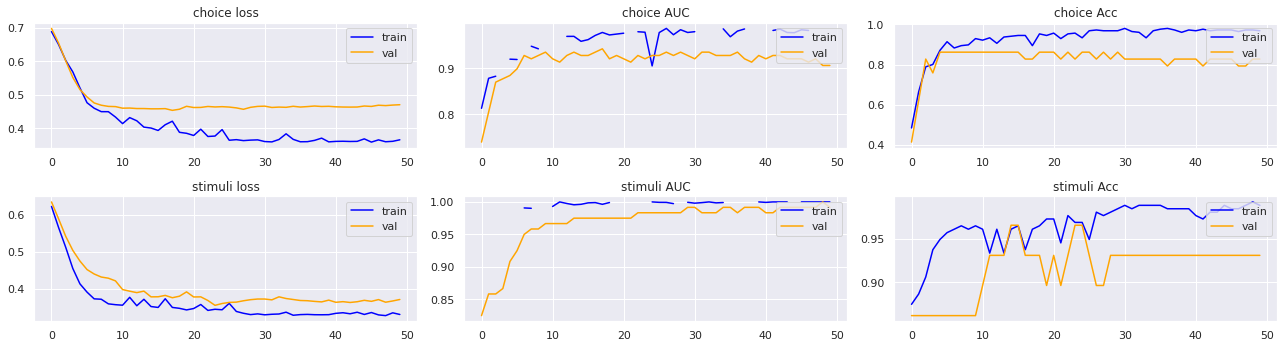

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18,5))
axes[0,0].plot(train_losses[:,0], color='blue', label='train')
axes[0,0].plot(val_losses[:,0], color='orange', label='val')
axes[0,0].set_title('choice loss')
axes[0,0].legend(loc=1)

axes[0,1].plot(train_losses[:,1], color='blue', label='train')
axes[0,1].plot(val_losses[:,1], color='orange', label='val')
axes[0,1].set_title('choice AUC')
axes[0,1].legend(loc=1)

axes[0,2].plot(train_losses[:,2], color='blue', label='train')
axes[0,2].plot(val_losses[:,2], color='orange', label='val')
axes[0,2].set_title('choice Acc')
axes[0,2].legend(loc=1)

axes[1,0].plot(train_losses[:,3], color='blue', label='train')
axes[1,0].plot(val_losses[:,3], color='orange', label='val')
axes[1,0].set_title('stimuli loss')
axes[1,0].legend(loc=1)

axes[1,1].plot(train_losses[:,4], color='blue', label='train')
axes[1,1].plot(val_losses[:,4], color='orange', label='val')
axes[1,1].set_title('stimuli AUC')
axes[1,1].legend(loc=1)

axes[1,2].plot(train_losses[:,5], color='blue', label='train')
axes[1,2].plot(val_losses[:,5], color='orange', label='val')
axes[1,2].set_title('stimuli Acc')
axes[1,2].legend(loc=1)

plt.tight_layout()

In [ ]:
model.eval()
choice_pred_lst = []
choice_true_lst = []
stimuli_pred_lst = []
stimuli_true_lst = []
for index, batch in enumerate(test_loader):
    batch_ts, batch_seqs, batch_masks, batch_choices, batch_stimuli = map(lambda x: cast(x, device), batch)
    choice_preds, stimuli_preds = model(batch_seqs, batch_ts, batch_masks)
    choice_pred_lst.append(choice_preds)
    choice_true_lst.append(batch_choices);
    stimuli_pred_lst.append(stimuli_preds)
    stimuli_true_lst.append(batch_stimuli);

In [ ]:
print('Test average AUC: {:.2f}'.format(roc_auc_score(flatten_for_auc(choice_true_lst), flatten_for_auc(choice_pred_lst))))
print('Test average Accuracy: {:.2f}'.format(accuracy_score(flatten_for_acc(choice_true_lst), flatten_for_acc(choice_pred_lst))))

Test average AUC: 0.98
Test average Accuracy: 0.90


In [ ]:
print('Test average AUC: {:.2f}'.format(roc_auc_score(flatten_for_auc(stimuli_true_lst), flatten_for_auc(stimuli_pred_lst))))
print('Test average Accuracy: {:.2f}'.format(accuracy_score(flatten_for_acc(stimuli_true_lst), flatten_for_acc(stimuli_pred_lst))))

Test average AUC: 1.00
Test average Accuracy: 1.00


In [ ]:
print(choice_pred_lst)
print(stimuli_pred_lst)

[tensor([[9.9672e-01, 3.2791e-03],
        [9.3327e-01, 6.6727e-02],
        [9.9749e-01, 2.5115e-03],
        [9.8137e-01, 1.8634e-02],
        [9.9993e-01, 6.5635e-05],
        [2.2304e-01, 7.7696e-01],
        [8.9275e-01, 1.0725e-01],
        [9.0691e-01, 9.3093e-02],
        [9.9980e-01, 2.0233e-04],
        [5.5113e-02, 9.4489e-01],
        [9.5392e-01, 4.6077e-02],
        [4.0113e-01, 5.9887e-01],
        [9.9653e-01, 3.4728e-03],
        [9.8079e-01, 1.9211e-02],
        [9.9997e-01, 2.7455e-05],
        [7.7530e-01, 2.2470e-01],
        [9.8731e-01, 1.2688e-02],
        [4.1711e-01, 5.8289e-01],
        [7.9285e-01, 2.0715e-01],
        [9.9238e-01, 7.6207e-03],
        [8.9109e-01, 1.0891e-01],
        [9.7537e-01, 2.4634e-02],
        [4.2169e-01, 5.7831e-01],
        [4.3324e-01, 5.6676e-01],
        [9.8824e-01, 1.1759e-02],
        [9.7267e-01, 2.7334e-02],
        [2.5133e-01, 7.4867e-01],
        [9.8235e-01, 1.7648e-02],
        [5.3174e-01, 4.6826e-01]], device='cuda

Cross Validation

In [ ]:
def CV_eval_loss(model, test_loader, device):
    model.eval()
    choice_loss_meter = AverageMeter()
    choice_auc_meter = AverageMeter()
    choice_acc_meter = AverageMeter()
    stimuli_loss_meter = AverageMeter()
    stimuli_auc_meter = AverageMeter()
    stimuli_acc_meter = AverageMeter()
    
    for index, batch in enumerate(test_loader):
        batch_ts, batch_seqs, batch_masks, batch_choices, batch_stimuli = map(lambda x: cast(x, device), batch)
        choice_true = batch_choices.cpu().detach().numpy()
        stimuli_true = batch_stimuli.cpu().detach().numpy()
        choice_preds, stimuli_preds = model(batch_seqs, batch_ts, batch_masks)
        choice_preds, stimuli_preds = choice_preds.cpu().detach().numpy(), stimuli_preds.cpu().detach().numpy()
        choice_loss, stimuli_loss = model.loss(batch_seqs, batch_ts, batch_masks, batch_choices, batch_stimuli)
        choice_loss_meter.update(choice_loss.item())
        stimuli_loss_meter.update(stimuli_loss.item())
        auc = np.infty
        try:
            auc = roc_auc_score(choice_true, choice_preds)
        except ValueError as e:
            print('Only one class present in y_true. ROC AUC score is not defined in that case.')
        choice_auc_meter.update(auc)
        acc = accuracy_score(choice_true.argmax(1), choice_preds.argmax(1))
        choice_acc_meter.update(acc)

        auc = np.infty
        try:
            auc = roc_auc_score(stimuli_true, stimuli_preds)
        except ValueError as e:
            print('Only one class present in y_true. ROC AUC score is not defined in that case.')
        stimuli_auc_meter.update(auc)
        acc = accuracy_score(stimuli_true.argmax(1), stimuli_preds.argmax(1))
        stimuli_acc_meter.update(acc)
        
    return choice_loss_meter.avg, choice_auc_meter.avg, choice_acc_meter.avg, stimuli_loss_meter.avg, stimuli_auc_meter.avg, stimuli_acc_meter.avg

In [ ]:
def CV_train(model, train_loader, config, logger, device):
    scheduler = torch.optim.lr_scheduler.StepLR(model.optimizer, step_size=30, gamma=0.1)
    loss_meter = AverageMeter()

    for epoch in trange(config.epochs):
        loss_total = 0
        model.train()
        for index, batch in tenumerate(train_loader):
            batch_ts, batch_seqs, batch_masks, batch_choices, batch_stimuli = map(lambda x: cast(x, device), batch)

            model.optimizer.zero_grad()
            choice_loss, stimuli_loss = model.loss(batch_seqs, batch_ts, batch_masks, batch_choices, batch_stimuli)
            total_loss = choice_loss + stimuli_loss

            if torch.isnan(total_loss):
                print("Numerical error, quiting...")
                return model

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=config.clip)
            model.optimizer.step()

            loss_meter.update(total_loss.item())

        scheduler.step()

        logger.info("Epoch {} | "
                    "Total loss: {:5f}".format(
            epoch, loss_meter.avg
        ))
  
    return model

In [ ]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

config = Namespace(hid_dim=32, emb_dim=32, n_feature=4,
                   lr=1e-4, momentum=0.9, weight_decay=1e-6,
                   epochs=50, batch=32, opt='Adam', 
                   seq_len=max_seq_len, eval_epoch=1,
                   drop_out=0.1, num_head=1,
                   n_trans_layers=3, clip=1e7)

In [ ]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle = True, random_state = 0)

fold = 0
cv_c_accs = []
cv_c_aucs = []
cv_s_accs = []
cv_s_aucs = []

for fold, (train_idx, test_idx) in enumerate(kfold.split(all_trials, choices.argmax(1))):

    gc.collect()
    torch.cuda.empty_cache()

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold} ...')

    train_set = NeuralData(split="train", train_ids=train_idx, val_ids=None, test_ids=test_idx)
    test_set = NeuralData(split="test", train_ids=train_idx, val_ids=None, test_ids=test_idx)

    train_loader = torch.utils.data.DataLoader(
        dataset=train_set,
        batch_size=32,
        shuffle=True,
        collate_fn=spatiotemporal_events_collate_fn,
    )
    test_loader = torch.utils.data.DataLoader(
        dataset=test_set,
        batch_size=32,
        shuffle=False,
        collate_fn=spatiotemporal_events_collate_fn,
    )

    model = Multi_Task_Encoder_Decoder(config, device)
    model.apply(reset_weights)
    model = CV_train(model, train_loader, config, logger, device)

    _, c_auc, c_acc, _, s_auc, s_acc = CV_eval_loss(model, test_loader, device)
    cv_c_accs.append(c_auc)
    cv_c_aucs.append(c_acc)
    cv_s_accs.append(s_auc)
    cv_s_aucs.append(s_acc)
    print(f'Test choice accuracy: {c_auc} AUC: {c_acc}.')
    print(f'Test stimuli accuracy: {s_auc} AUC: {s_acc}.')

print(f'Average {fold+1}-fold CV choice accuracy: {np.mean(cv_c_accs)} AUC: {np.mean(cv_c_aucs)}.')
print(f'Average {fold+1}-fold CV stimuli accuracy: {np.mean(cv_s_accs)} AUC: {np.mean(cv_s_aucs)}.')

------------------------------------------------------------------------
Training for fold 0 ...
Reset trainable parameters of layer = NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = LayerNorm((32,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = LayerNorm((32,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = LayerNorm((32,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = LayerNor

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:45,678 INFO Epoch 0 | Total loss: 1.265988
2022-07-20 22:18:45,678 INFO Epoch 0 | Total loss: 1.265988
2022-07-20 22:18:45,678 INFO Epoch 0 | Total loss: 1.265988
INFO:batch32:Epoch 0 | Total loss: 1.265988


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:46,025 INFO Epoch 1 | Total loss: 1.210348
2022-07-20 22:18:46,025 INFO Epoch 1 | Total loss: 1.210348
2022-07-20 22:18:46,025 INFO Epoch 1 | Total loss: 1.210348
INFO:batch32:Epoch 1 | Total loss: 1.210348


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:46,358 INFO Epoch 2 | Total loss: 1.159161
2022-07-20 22:18:46,358 INFO Epoch 2 | Total loss: 1.159161
2022-07-20 22:18:46,358 INFO Epoch 2 | Total loss: 1.159161
INFO:batch32:Epoch 2 | Total loss: 1.159161


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:46,707 INFO Epoch 3 | Total loss: 1.120675
2022-07-20 22:18:46,707 INFO Epoch 3 | Total loss: 1.120675
2022-07-20 22:18:46,707 INFO Epoch 3 | Total loss: 1.120675
INFO:batch32:Epoch 3 | Total loss: 1.120675


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:47,037 INFO Epoch 4 | Total loss: 1.087208
2022-07-20 22:18:47,037 INFO Epoch 4 | Total loss: 1.087208
2022-07-20 22:18:47,037 INFO Epoch 4 | Total loss: 1.087208
INFO:batch32:Epoch 4 | Total loss: 1.087208


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:47,365 INFO Epoch 5 | Total loss: 1.066255
2022-07-20 22:18:47,365 INFO Epoch 5 | Total loss: 1.066255
2022-07-20 22:18:47,365 INFO Epoch 5 | Total loss: 1.066255
INFO:batch32:Epoch 5 | Total loss: 1.066255


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:47,718 INFO Epoch 6 | Total loss: 1.042795
2022-07-20 22:18:47,718 INFO Epoch 6 | Total loss: 1.042795
2022-07-20 22:18:47,718 INFO Epoch 6 | Total loss: 1.042795
INFO:batch32:Epoch 6 | Total loss: 1.042795


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:48,057 INFO Epoch 7 | Total loss: 1.026858
2022-07-20 22:18:48,057 INFO Epoch 7 | Total loss: 1.026858
2022-07-20 22:18:48,057 INFO Epoch 7 | Total loss: 1.026858
INFO:batch32:Epoch 7 | Total loss: 1.026858


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:48,389 INFO Epoch 8 | Total loss: 1.009199
2022-07-20 22:18:48,389 INFO Epoch 8 | Total loss: 1.009199
2022-07-20 22:18:48,389 INFO Epoch 8 | Total loss: 1.009199
INFO:batch32:Epoch 8 | Total loss: 1.009199


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:48,728 INFO Epoch 9 | Total loss: 0.994205
2022-07-20 22:18:48,728 INFO Epoch 9 | Total loss: 0.994205
2022-07-20 22:18:48,728 INFO Epoch 9 | Total loss: 0.994205
INFO:batch32:Epoch 9 | Total loss: 0.994205


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:49,064 INFO Epoch 10 | Total loss: 0.981612
2022-07-20 22:18:49,064 INFO Epoch 10 | Total loss: 0.981612
2022-07-20 22:18:49,064 INFO Epoch 10 | Total loss: 0.981612
INFO:batch32:Epoch 10 | Total loss: 0.981612


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:49,411 INFO Epoch 11 | Total loss: 0.971622
2022-07-20 22:18:49,411 INFO Epoch 11 | Total loss: 0.971622
2022-07-20 22:18:49,411 INFO Epoch 11 | Total loss: 0.971622
INFO:batch32:Epoch 11 | Total loss: 0.971622


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:49,752 INFO Epoch 12 | Total loss: 0.959425
2022-07-20 22:18:49,752 INFO Epoch 12 | Total loss: 0.959425
2022-07-20 22:18:49,752 INFO Epoch 12 | Total loss: 0.959425
INFO:batch32:Epoch 12 | Total loss: 0.959425


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:50,082 INFO Epoch 13 | Total loss: 0.948641
2022-07-20 22:18:50,082 INFO Epoch 13 | Total loss: 0.948641
2022-07-20 22:18:50,082 INFO Epoch 13 | Total loss: 0.948641
INFO:batch32:Epoch 13 | Total loss: 0.948641


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:50,428 INFO Epoch 14 | Total loss: 0.943180
2022-07-20 22:18:50,428 INFO Epoch 14 | Total loss: 0.943180
2022-07-20 22:18:50,428 INFO Epoch 14 | Total loss: 0.943180
INFO:batch32:Epoch 14 | Total loss: 0.943180


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:50,762 INFO Epoch 15 | Total loss: 0.933373
2022-07-20 22:18:50,762 INFO Epoch 15 | Total loss: 0.933373
2022-07-20 22:18:50,762 INFO Epoch 15 | Total loss: 0.933373
INFO:batch32:Epoch 15 | Total loss: 0.933373


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:51,087 INFO Epoch 16 | Total loss: 0.924266
2022-07-20 22:18:51,087 INFO Epoch 16 | Total loss: 0.924266
2022-07-20 22:18:51,087 INFO Epoch 16 | Total loss: 0.924266
INFO:batch32:Epoch 16 | Total loss: 0.924266


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:51,429 INFO Epoch 17 | Total loss: 0.916605
2022-07-20 22:18:51,429 INFO Epoch 17 | Total loss: 0.916605
2022-07-20 22:18:51,429 INFO Epoch 17 | Total loss: 0.916605
INFO:batch32:Epoch 17 | Total loss: 0.916605


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:51,782 INFO Epoch 18 | Total loss: 0.911701
2022-07-20 22:18:51,782 INFO Epoch 18 | Total loss: 0.911701
2022-07-20 22:18:51,782 INFO Epoch 18 | Total loss: 0.911701
INFO:batch32:Epoch 18 | Total loss: 0.911701


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:52,135 INFO Epoch 19 | Total loss: 0.905513
2022-07-20 22:18:52,135 INFO Epoch 19 | Total loss: 0.905513
2022-07-20 22:18:52,135 INFO Epoch 19 | Total loss: 0.905513
INFO:batch32:Epoch 19 | Total loss: 0.905513


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:52,469 INFO Epoch 20 | Total loss: 0.898284
2022-07-20 22:18:52,469 INFO Epoch 20 | Total loss: 0.898284
2022-07-20 22:18:52,469 INFO Epoch 20 | Total loss: 0.898284
INFO:batch32:Epoch 20 | Total loss: 0.898284


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:52,817 INFO Epoch 21 | Total loss: 0.891510
2022-07-20 22:18:52,817 INFO Epoch 21 | Total loss: 0.891510
2022-07-20 22:18:52,817 INFO Epoch 21 | Total loss: 0.891510
INFO:batch32:Epoch 21 | Total loss: 0.891510


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:53,155 INFO Epoch 22 | Total loss: 0.885239
2022-07-20 22:18:53,155 INFO Epoch 22 | Total loss: 0.885239
2022-07-20 22:18:53,155 INFO Epoch 22 | Total loss: 0.885239
INFO:batch32:Epoch 22 | Total loss: 0.885239


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:53,500 INFO Epoch 23 | Total loss: 0.879619
2022-07-20 22:18:53,500 INFO Epoch 23 | Total loss: 0.879619
2022-07-20 22:18:53,500 INFO Epoch 23 | Total loss: 0.879619
INFO:batch32:Epoch 23 | Total loss: 0.879619


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:53,842 INFO Epoch 24 | Total loss: 0.874246
2022-07-20 22:18:53,842 INFO Epoch 24 | Total loss: 0.874246
2022-07-20 22:18:53,842 INFO Epoch 24 | Total loss: 0.874246
INFO:batch32:Epoch 24 | Total loss: 0.874246


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:54,196 INFO Epoch 25 | Total loss: 0.869893
2022-07-20 22:18:54,196 INFO Epoch 25 | Total loss: 0.869893
2022-07-20 22:18:54,196 INFO Epoch 25 | Total loss: 0.869893
INFO:batch32:Epoch 25 | Total loss: 0.869893


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:54,562 INFO Epoch 26 | Total loss: 0.865555
2022-07-20 22:18:54,562 INFO Epoch 26 | Total loss: 0.865555
2022-07-20 22:18:54,562 INFO Epoch 26 | Total loss: 0.865555
INFO:batch32:Epoch 26 | Total loss: 0.865555


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:54,905 INFO Epoch 27 | Total loss: 0.861971
2022-07-20 22:18:54,905 INFO Epoch 27 | Total loss: 0.861971
2022-07-20 22:18:54,905 INFO Epoch 27 | Total loss: 0.861971
INFO:batch32:Epoch 27 | Total loss: 0.861971


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:55,239 INFO Epoch 28 | Total loss: 0.857589
2022-07-20 22:18:55,239 INFO Epoch 28 | Total loss: 0.857589
2022-07-20 22:18:55,239 INFO Epoch 28 | Total loss: 0.857589
INFO:batch32:Epoch 28 | Total loss: 0.857589


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:55,579 INFO Epoch 29 | Total loss: 0.853868
2022-07-20 22:18:55,579 INFO Epoch 29 | Total loss: 0.853868
2022-07-20 22:18:55,579 INFO Epoch 29 | Total loss: 0.853868
INFO:batch32:Epoch 29 | Total loss: 0.853868


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:55,930 INFO Epoch 30 | Total loss: 0.850565
2022-07-20 22:18:55,930 INFO Epoch 30 | Total loss: 0.850565
2022-07-20 22:18:55,930 INFO Epoch 30 | Total loss: 0.850565
INFO:batch32:Epoch 30 | Total loss: 0.850565


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:56,274 INFO Epoch 31 | Total loss: 0.847414
2022-07-20 22:18:56,274 INFO Epoch 31 | Total loss: 0.847414
2022-07-20 22:18:56,274 INFO Epoch 31 | Total loss: 0.847414
INFO:batch32:Epoch 31 | Total loss: 0.847414


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:56,613 INFO Epoch 32 | Total loss: 0.843534
2022-07-20 22:18:56,613 INFO Epoch 32 | Total loss: 0.843534
2022-07-20 22:18:56,613 INFO Epoch 32 | Total loss: 0.843534
INFO:batch32:Epoch 32 | Total loss: 0.843534


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:56,968 INFO Epoch 33 | Total loss: 0.841244
2022-07-20 22:18:56,968 INFO Epoch 33 | Total loss: 0.841244
2022-07-20 22:18:56,968 INFO Epoch 33 | Total loss: 0.841244
INFO:batch32:Epoch 33 | Total loss: 0.841244


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:57,335 INFO Epoch 34 | Total loss: 0.837909
2022-07-20 22:18:57,335 INFO Epoch 34 | Total loss: 0.837909
2022-07-20 22:18:57,335 INFO Epoch 34 | Total loss: 0.837909
INFO:batch32:Epoch 34 | Total loss: 0.837909


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:57,681 INFO Epoch 35 | Total loss: 0.835028
2022-07-20 22:18:57,681 INFO Epoch 35 | Total loss: 0.835028
2022-07-20 22:18:57,681 INFO Epoch 35 | Total loss: 0.835028
INFO:batch32:Epoch 35 | Total loss: 0.835028


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:58,046 INFO Epoch 36 | Total loss: 0.833430
2022-07-20 22:18:58,046 INFO Epoch 36 | Total loss: 0.833430
2022-07-20 22:18:58,046 INFO Epoch 36 | Total loss: 0.833430
INFO:batch32:Epoch 36 | Total loss: 0.833430


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:58,388 INFO Epoch 37 | Total loss: 0.831216
2022-07-20 22:18:58,388 INFO Epoch 37 | Total loss: 0.831216
2022-07-20 22:18:58,388 INFO Epoch 37 | Total loss: 0.831216
INFO:batch32:Epoch 37 | Total loss: 0.831216


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:58,718 INFO Epoch 38 | Total loss: 0.828534
2022-07-20 22:18:58,718 INFO Epoch 38 | Total loss: 0.828534
2022-07-20 22:18:58,718 INFO Epoch 38 | Total loss: 0.828534
INFO:batch32:Epoch 38 | Total loss: 0.828534


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:59,062 INFO Epoch 39 | Total loss: 0.826124
2022-07-20 22:18:59,062 INFO Epoch 39 | Total loss: 0.826124
2022-07-20 22:18:59,062 INFO Epoch 39 | Total loss: 0.826124
INFO:batch32:Epoch 39 | Total loss: 0.826124


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:59,403 INFO Epoch 40 | Total loss: 0.824316
2022-07-20 22:18:59,403 INFO Epoch 40 | Total loss: 0.824316
2022-07-20 22:18:59,403 INFO Epoch 40 | Total loss: 0.824316
INFO:batch32:Epoch 40 | Total loss: 0.824316


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:18:59,747 INFO Epoch 41 | Total loss: 0.823079
2022-07-20 22:18:59,747 INFO Epoch 41 | Total loss: 0.823079
2022-07-20 22:18:59,747 INFO Epoch 41 | Total loss: 0.823079
INFO:batch32:Epoch 41 | Total loss: 0.823079


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:00,098 INFO Epoch 42 | Total loss: 0.820685
2022-07-20 22:19:00,098 INFO Epoch 42 | Total loss: 0.820685
2022-07-20 22:19:00,098 INFO Epoch 42 | Total loss: 0.820685
INFO:batch32:Epoch 42 | Total loss: 0.820685


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:00,451 INFO Epoch 43 | Total loss: 0.818367
2022-07-20 22:19:00,451 INFO Epoch 43 | Total loss: 0.818367
2022-07-20 22:19:00,451 INFO Epoch 43 | Total loss: 0.818367
INFO:batch32:Epoch 43 | Total loss: 0.818367


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:00,811 INFO Epoch 44 | Total loss: 0.816028
2022-07-20 22:19:00,811 INFO Epoch 44 | Total loss: 0.816028
2022-07-20 22:19:00,811 INFO Epoch 44 | Total loss: 0.816028
INFO:batch32:Epoch 44 | Total loss: 0.816028


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:01,168 INFO Epoch 45 | Total loss: 0.813772
2022-07-20 22:19:01,168 INFO Epoch 45 | Total loss: 0.813772
2022-07-20 22:19:01,168 INFO Epoch 45 | Total loss: 0.813772
INFO:batch32:Epoch 45 | Total loss: 0.813772


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:01,519 INFO Epoch 46 | Total loss: 0.811787
2022-07-20 22:19:01,519 INFO Epoch 46 | Total loss: 0.811787
2022-07-20 22:19:01,519 INFO Epoch 46 | Total loss: 0.811787
INFO:batch32:Epoch 46 | Total loss: 0.811787


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:01,865 INFO Epoch 47 | Total loss: 0.810367
2022-07-20 22:19:01,865 INFO Epoch 47 | Total loss: 0.810367
2022-07-20 22:19:01,865 INFO Epoch 47 | Total loss: 0.810367
INFO:batch32:Epoch 47 | Total loss: 0.810367


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:02,218 INFO Epoch 48 | Total loss: 0.808542
2022-07-20 22:19:02,218 INFO Epoch 48 | Total loss: 0.808542
2022-07-20 22:19:02,218 INFO Epoch 48 | Total loss: 0.808542
INFO:batch32:Epoch 48 | Total loss: 0.808542


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:02,558 INFO Epoch 49 | Total loss: 0.807003
2022-07-20 22:19:02,558 INFO Epoch 49 | Total loss: 0.807003
2022-07-20 22:19:02,558 INFO Epoch 49 | Total loss: 0.807003
INFO:batch32:Epoch 49 | Total loss: 0.807003


Test choice accuracy: 0.9227272727272727 AUC: 0.8677884615384616.
Test stimuli accuracy: 0.9879227053140096 AUC: 0.9651442307692308.
------------------------------------------------------------------------
Training for fold 1 ...
Reset trainable parameters of layer = NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = LayerNorm((32,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = LayerNorm((32,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=32, bias=True)
Rese

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:03,464 INFO Epoch 0 | Total loss: 1.330050
2022-07-20 22:19:03,464 INFO Epoch 0 | Total loss: 1.330050
2022-07-20 22:19:03,464 INFO Epoch 0 | Total loss: 1.330050
INFO:batch32:Epoch 0 | Total loss: 1.330050


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:03,812 INFO Epoch 1 | Total loss: 1.240697
2022-07-20 22:19:03,812 INFO Epoch 1 | Total loss: 1.240697
2022-07-20 22:19:03,812 INFO Epoch 1 | Total loss: 1.240697
INFO:batch32:Epoch 1 | Total loss: 1.240697


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:04,177 INFO Epoch 2 | Total loss: 1.189695
2022-07-20 22:19:04,177 INFO Epoch 2 | Total loss: 1.189695
2022-07-20 22:19:04,177 INFO Epoch 2 | Total loss: 1.189695
INFO:batch32:Epoch 2 | Total loss: 1.189695


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:04,536 INFO Epoch 3 | Total loss: 1.148095
2022-07-20 22:19:04,536 INFO Epoch 3 | Total loss: 1.148095
2022-07-20 22:19:04,536 INFO Epoch 3 | Total loss: 1.148095
INFO:batch32:Epoch 3 | Total loss: 1.148095


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:04,875 INFO Epoch 4 | Total loss: 1.111184
2022-07-20 22:19:04,875 INFO Epoch 4 | Total loss: 1.111184
2022-07-20 22:19:04,875 INFO Epoch 4 | Total loss: 1.111184
INFO:batch32:Epoch 4 | Total loss: 1.111184


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:05,228 INFO Epoch 5 | Total loss: 1.077486
2022-07-20 22:19:05,228 INFO Epoch 5 | Total loss: 1.077486
2022-07-20 22:19:05,228 INFO Epoch 5 | Total loss: 1.077486
INFO:batch32:Epoch 5 | Total loss: 1.077486


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:05,590 INFO Epoch 6 | Total loss: 1.052557
2022-07-20 22:19:05,590 INFO Epoch 6 | Total loss: 1.052557
2022-07-20 22:19:05,590 INFO Epoch 6 | Total loss: 1.052557
INFO:batch32:Epoch 6 | Total loss: 1.052557


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:05,933 INFO Epoch 7 | Total loss: 1.029717
2022-07-20 22:19:05,933 INFO Epoch 7 | Total loss: 1.029717
2022-07-20 22:19:05,933 INFO Epoch 7 | Total loss: 1.029717
INFO:batch32:Epoch 7 | Total loss: 1.029717


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:06,289 INFO Epoch 8 | Total loss: 1.009225
2022-07-20 22:19:06,289 INFO Epoch 8 | Total loss: 1.009225
2022-07-20 22:19:06,289 INFO Epoch 8 | Total loss: 1.009225
INFO:batch32:Epoch 8 | Total loss: 1.009225


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:06,630 INFO Epoch 9 | Total loss: 0.992737
2022-07-20 22:19:06,630 INFO Epoch 9 | Total loss: 0.992737
2022-07-20 22:19:06,630 INFO Epoch 9 | Total loss: 0.992737
INFO:batch32:Epoch 9 | Total loss: 0.992737


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:06,967 INFO Epoch 10 | Total loss: 0.981219
2022-07-20 22:19:06,967 INFO Epoch 10 | Total loss: 0.981219
2022-07-20 22:19:06,967 INFO Epoch 10 | Total loss: 0.981219
INFO:batch32:Epoch 10 | Total loss: 0.981219


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:07,317 INFO Epoch 11 | Total loss: 0.967598
2022-07-20 22:19:07,317 INFO Epoch 11 | Total loss: 0.967598
2022-07-20 22:19:07,317 INFO Epoch 11 | Total loss: 0.967598
INFO:batch32:Epoch 11 | Total loss: 0.967598


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:07,672 INFO Epoch 12 | Total loss: 0.957351
2022-07-20 22:19:07,672 INFO Epoch 12 | Total loss: 0.957351
2022-07-20 22:19:07,672 INFO Epoch 12 | Total loss: 0.957351
INFO:batch32:Epoch 12 | Total loss: 0.957351


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:08,026 INFO Epoch 13 | Total loss: 0.948806
2022-07-20 22:19:08,026 INFO Epoch 13 | Total loss: 0.948806
2022-07-20 22:19:08,026 INFO Epoch 13 | Total loss: 0.948806
INFO:batch32:Epoch 13 | Total loss: 0.948806


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:08,434 INFO Epoch 14 | Total loss: 0.940646
2022-07-20 22:19:08,434 INFO Epoch 14 | Total loss: 0.940646
2022-07-20 22:19:08,434 INFO Epoch 14 | Total loss: 0.940646
INFO:batch32:Epoch 14 | Total loss: 0.940646


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:08,781 INFO Epoch 15 | Total loss: 0.930536
2022-07-20 22:19:08,781 INFO Epoch 15 | Total loss: 0.930536
2022-07-20 22:19:08,781 INFO Epoch 15 | Total loss: 0.930536
INFO:batch32:Epoch 15 | Total loss: 0.930536


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:09,135 INFO Epoch 16 | Total loss: 0.922137
2022-07-20 22:19:09,135 INFO Epoch 16 | Total loss: 0.922137
2022-07-20 22:19:09,135 INFO Epoch 16 | Total loss: 0.922137
INFO:batch32:Epoch 16 | Total loss: 0.922137


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:09,509 INFO Epoch 17 | Total loss: 0.915665
2022-07-20 22:19:09,509 INFO Epoch 17 | Total loss: 0.915665
2022-07-20 22:19:09,509 INFO Epoch 17 | Total loss: 0.915665
INFO:batch32:Epoch 17 | Total loss: 0.915665


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:09,886 INFO Epoch 18 | Total loss: 0.907949
2022-07-20 22:19:09,886 INFO Epoch 18 | Total loss: 0.907949
2022-07-20 22:19:09,886 INFO Epoch 18 | Total loss: 0.907949
INFO:batch32:Epoch 18 | Total loss: 0.907949


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:10,239 INFO Epoch 19 | Total loss: 0.901187
2022-07-20 22:19:10,239 INFO Epoch 19 | Total loss: 0.901187
2022-07-20 22:19:10,239 INFO Epoch 19 | Total loss: 0.901187
INFO:batch32:Epoch 19 | Total loss: 0.901187


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:10,606 INFO Epoch 20 | Total loss: 0.895021
2022-07-20 22:19:10,606 INFO Epoch 20 | Total loss: 0.895021
2022-07-20 22:19:10,606 INFO Epoch 20 | Total loss: 0.895021
INFO:batch32:Epoch 20 | Total loss: 0.895021


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:10,976 INFO Epoch 21 | Total loss: 0.888605
2022-07-20 22:19:10,976 INFO Epoch 21 | Total loss: 0.888605
2022-07-20 22:19:10,976 INFO Epoch 21 | Total loss: 0.888605
INFO:batch32:Epoch 21 | Total loss: 0.888605


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:11,353 INFO Epoch 22 | Total loss: 0.882902
2022-07-20 22:19:11,353 INFO Epoch 22 | Total loss: 0.882902
2022-07-20 22:19:11,353 INFO Epoch 22 | Total loss: 0.882902
INFO:batch32:Epoch 22 | Total loss: 0.882902


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:11,692 INFO Epoch 23 | Total loss: 0.878643
2022-07-20 22:19:11,692 INFO Epoch 23 | Total loss: 0.878643
2022-07-20 22:19:11,692 INFO Epoch 23 | Total loss: 0.878643
INFO:batch32:Epoch 23 | Total loss: 0.878643


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:12,066 INFO Epoch 24 | Total loss: 0.874100
2022-07-20 22:19:12,066 INFO Epoch 24 | Total loss: 0.874100
2022-07-20 22:19:12,066 INFO Epoch 24 | Total loss: 0.874100
INFO:batch32:Epoch 24 | Total loss: 0.874100


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:12,415 INFO Epoch 25 | Total loss: 0.870266
2022-07-20 22:19:12,415 INFO Epoch 25 | Total loss: 0.870266
2022-07-20 22:19:12,415 INFO Epoch 25 | Total loss: 0.870266
INFO:batch32:Epoch 25 | Total loss: 0.870266


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:12,757 INFO Epoch 26 | Total loss: 0.866237
2022-07-20 22:19:12,757 INFO Epoch 26 | Total loss: 0.866237
2022-07-20 22:19:12,757 INFO Epoch 26 | Total loss: 0.866237
INFO:batch32:Epoch 26 | Total loss: 0.866237


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:13,130 INFO Epoch 27 | Total loss: 0.862767
2022-07-20 22:19:13,130 INFO Epoch 27 | Total loss: 0.862767
2022-07-20 22:19:13,130 INFO Epoch 27 | Total loss: 0.862767
INFO:batch32:Epoch 27 | Total loss: 0.862767


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:13,503 INFO Epoch 28 | Total loss: 0.858768
2022-07-20 22:19:13,503 INFO Epoch 28 | Total loss: 0.858768
2022-07-20 22:19:13,503 INFO Epoch 28 | Total loss: 0.858768
INFO:batch32:Epoch 28 | Total loss: 0.858768


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:13,852 INFO Epoch 29 | Total loss: 0.855022
2022-07-20 22:19:13,852 INFO Epoch 29 | Total loss: 0.855022
2022-07-20 22:19:13,852 INFO Epoch 29 | Total loss: 0.855022
INFO:batch32:Epoch 29 | Total loss: 0.855022


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:14,230 INFO Epoch 30 | Total loss: 0.852072
2022-07-20 22:19:14,230 INFO Epoch 30 | Total loss: 0.852072
2022-07-20 22:19:14,230 INFO Epoch 30 | Total loss: 0.852072
INFO:batch32:Epoch 30 | Total loss: 0.852072


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:14,612 INFO Epoch 31 | Total loss: 0.848724
2022-07-20 22:19:14,612 INFO Epoch 31 | Total loss: 0.848724
2022-07-20 22:19:14,612 INFO Epoch 31 | Total loss: 0.848724
INFO:batch32:Epoch 31 | Total loss: 0.848724


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:14,974 INFO Epoch 32 | Total loss: 0.845564
2022-07-20 22:19:14,974 INFO Epoch 32 | Total loss: 0.845564
2022-07-20 22:19:14,974 INFO Epoch 32 | Total loss: 0.845564
INFO:batch32:Epoch 32 | Total loss: 0.845564


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:15,319 INFO Epoch 33 | Total loss: 0.841883
2022-07-20 22:19:15,319 INFO Epoch 33 | Total loss: 0.841883
2022-07-20 22:19:15,319 INFO Epoch 33 | Total loss: 0.841883
INFO:batch32:Epoch 33 | Total loss: 0.841883


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:15,683 INFO Epoch 34 | Total loss: 0.838557
2022-07-20 22:19:15,683 INFO Epoch 34 | Total loss: 0.838557
2022-07-20 22:19:15,683 INFO Epoch 34 | Total loss: 0.838557
INFO:batch32:Epoch 34 | Total loss: 0.838557


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:16,042 INFO Epoch 35 | Total loss: 0.835994
2022-07-20 22:19:16,042 INFO Epoch 35 | Total loss: 0.835994
2022-07-20 22:19:16,042 INFO Epoch 35 | Total loss: 0.835994
INFO:batch32:Epoch 35 | Total loss: 0.835994


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:16,389 INFO Epoch 36 | Total loss: 0.833736
2022-07-20 22:19:16,389 INFO Epoch 36 | Total loss: 0.833736
2022-07-20 22:19:16,389 INFO Epoch 36 | Total loss: 0.833736
INFO:batch32:Epoch 36 | Total loss: 0.833736


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:16,763 INFO Epoch 37 | Total loss: 0.831344
2022-07-20 22:19:16,763 INFO Epoch 37 | Total loss: 0.831344
2022-07-20 22:19:16,763 INFO Epoch 37 | Total loss: 0.831344
INFO:batch32:Epoch 37 | Total loss: 0.831344


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:17,147 INFO Epoch 38 | Total loss: 0.829205
2022-07-20 22:19:17,147 INFO Epoch 38 | Total loss: 0.829205
2022-07-20 22:19:17,147 INFO Epoch 38 | Total loss: 0.829205
INFO:batch32:Epoch 38 | Total loss: 0.829205


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:17,510 INFO Epoch 39 | Total loss: 0.826806
2022-07-20 22:19:17,510 INFO Epoch 39 | Total loss: 0.826806
2022-07-20 22:19:17,510 INFO Epoch 39 | Total loss: 0.826806
INFO:batch32:Epoch 39 | Total loss: 0.826806


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:17,890 INFO Epoch 40 | Total loss: 0.824435
2022-07-20 22:19:17,890 INFO Epoch 40 | Total loss: 0.824435
2022-07-20 22:19:17,890 INFO Epoch 40 | Total loss: 0.824435
INFO:batch32:Epoch 40 | Total loss: 0.824435


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:18,256 INFO Epoch 41 | Total loss: 0.822589
2022-07-20 22:19:18,256 INFO Epoch 41 | Total loss: 0.822589
2022-07-20 22:19:18,256 INFO Epoch 41 | Total loss: 0.822589
INFO:batch32:Epoch 41 | Total loss: 0.822589


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:18,650 INFO Epoch 42 | Total loss: 0.820388
2022-07-20 22:19:18,650 INFO Epoch 42 | Total loss: 0.820388
2022-07-20 22:19:18,650 INFO Epoch 42 | Total loss: 0.820388
INFO:batch32:Epoch 42 | Total loss: 0.820388


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:18,999 INFO Epoch 43 | Total loss: 0.818277
2022-07-20 22:19:18,999 INFO Epoch 43 | Total loss: 0.818277
2022-07-20 22:19:18,999 INFO Epoch 43 | Total loss: 0.818277
INFO:batch32:Epoch 43 | Total loss: 0.818277


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:19,343 INFO Epoch 44 | Total loss: 0.816222
2022-07-20 22:19:19,343 INFO Epoch 44 | Total loss: 0.816222
2022-07-20 22:19:19,343 INFO Epoch 44 | Total loss: 0.816222
INFO:batch32:Epoch 44 | Total loss: 0.816222


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:19,684 INFO Epoch 45 | Total loss: 0.814722
2022-07-20 22:19:19,684 INFO Epoch 45 | Total loss: 0.814722
2022-07-20 22:19:19,684 INFO Epoch 45 | Total loss: 0.814722
INFO:batch32:Epoch 45 | Total loss: 0.814722


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:20,060 INFO Epoch 46 | Total loss: 0.813179
2022-07-20 22:19:20,060 INFO Epoch 46 | Total loss: 0.813179
2022-07-20 22:19:20,060 INFO Epoch 46 | Total loss: 0.813179
INFO:batch32:Epoch 46 | Total loss: 0.813179


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:20,409 INFO Epoch 47 | Total loss: 0.812083
2022-07-20 22:19:20,409 INFO Epoch 47 | Total loss: 0.812083
2022-07-20 22:19:20,409 INFO Epoch 47 | Total loss: 0.812083
INFO:batch32:Epoch 47 | Total loss: 0.812083


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:20,778 INFO Epoch 48 | Total loss: 0.810723
2022-07-20 22:19:20,778 INFO Epoch 48 | Total loss: 0.810723
2022-07-20 22:19:20,778 INFO Epoch 48 | Total loss: 0.810723
INFO:batch32:Epoch 48 | Total loss: 0.810723


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:21,153 INFO Epoch 49 | Total loss: 0.809257
2022-07-20 22:19:21,153 INFO Epoch 49 | Total loss: 0.809257
2022-07-20 22:19:21,153 INFO Epoch 49 | Total loss: 0.809257
INFO:batch32:Epoch 49 | Total loss: 0.809257


Test choice accuracy: 0.9637681159420289 AUC: 0.9375.
Test stimuli accuracy: 1.0 AUC: 0.98.
------------------------------------------------------------------------
Training for fold 2 ...
Reset trainable parameters of layer = NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = LayerNorm((32,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = LayerNorm((32,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = LayerNo

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:22,066 INFO Epoch 0 | Total loss: 1.319913
2022-07-20 22:19:22,066 INFO Epoch 0 | Total loss: 1.319913
2022-07-20 22:19:22,066 INFO Epoch 0 | Total loss: 1.319913
INFO:batch32:Epoch 0 | Total loss: 1.319913


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:22,424 INFO Epoch 1 | Total loss: 1.236120
2022-07-20 22:19:22,424 INFO Epoch 1 | Total loss: 1.236120
2022-07-20 22:19:22,424 INFO Epoch 1 | Total loss: 1.236120
INFO:batch32:Epoch 1 | Total loss: 1.236120


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:22,784 INFO Epoch 2 | Total loss: 1.180323
2022-07-20 22:19:22,784 INFO Epoch 2 | Total loss: 1.180323
2022-07-20 22:19:22,784 INFO Epoch 2 | Total loss: 1.180323
INFO:batch32:Epoch 2 | Total loss: 1.180323


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:23,127 INFO Epoch 3 | Total loss: 1.133476
2022-07-20 22:19:23,127 INFO Epoch 3 | Total loss: 1.133476
2022-07-20 22:19:23,127 INFO Epoch 3 | Total loss: 1.133476
INFO:batch32:Epoch 3 | Total loss: 1.133476


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:23,478 INFO Epoch 4 | Total loss: 1.102333
2022-07-20 22:19:23,478 INFO Epoch 4 | Total loss: 1.102333
2022-07-20 22:19:23,478 INFO Epoch 4 | Total loss: 1.102333
INFO:batch32:Epoch 4 | Total loss: 1.102333


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:23,858 INFO Epoch 5 | Total loss: 1.076955
2022-07-20 22:19:23,858 INFO Epoch 5 | Total loss: 1.076955
2022-07-20 22:19:23,858 INFO Epoch 5 | Total loss: 1.076955
INFO:batch32:Epoch 5 | Total loss: 1.076955


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:24,235 INFO Epoch 6 | Total loss: 1.050612
2022-07-20 22:19:24,235 INFO Epoch 6 | Total loss: 1.050612
2022-07-20 22:19:24,235 INFO Epoch 6 | Total loss: 1.050612
INFO:batch32:Epoch 6 | Total loss: 1.050612


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:24,596 INFO Epoch 7 | Total loss: 1.027751
2022-07-20 22:19:24,596 INFO Epoch 7 | Total loss: 1.027751
2022-07-20 22:19:24,596 INFO Epoch 7 | Total loss: 1.027751
INFO:batch32:Epoch 7 | Total loss: 1.027751


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:24,966 INFO Epoch 8 | Total loss: 1.010705
2022-07-20 22:19:24,966 INFO Epoch 8 | Total loss: 1.010705
2022-07-20 22:19:24,966 INFO Epoch 8 | Total loss: 1.010705
INFO:batch32:Epoch 8 | Total loss: 1.010705


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:25,327 INFO Epoch 9 | Total loss: 0.994369
2022-07-20 22:19:25,327 INFO Epoch 9 | Total loss: 0.994369
2022-07-20 22:19:25,327 INFO Epoch 9 | Total loss: 0.994369
INFO:batch32:Epoch 9 | Total loss: 0.994369


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:25,688 INFO Epoch 10 | Total loss: 0.985171
2022-07-20 22:19:25,688 INFO Epoch 10 | Total loss: 0.985171
2022-07-20 22:19:25,688 INFO Epoch 10 | Total loss: 0.985171
INFO:batch32:Epoch 10 | Total loss: 0.985171


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:26,079 INFO Epoch 11 | Total loss: 0.970977
2022-07-20 22:19:26,079 INFO Epoch 11 | Total loss: 0.970977
2022-07-20 22:19:26,079 INFO Epoch 11 | Total loss: 0.970977
INFO:batch32:Epoch 11 | Total loss: 0.970977


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:26,426 INFO Epoch 12 | Total loss: 0.960851
2022-07-20 22:19:26,426 INFO Epoch 12 | Total loss: 0.960851
2022-07-20 22:19:26,426 INFO Epoch 12 | Total loss: 0.960851
INFO:batch32:Epoch 12 | Total loss: 0.960851


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:26,778 INFO Epoch 13 | Total loss: 0.950080
2022-07-20 22:19:26,778 INFO Epoch 13 | Total loss: 0.950080
2022-07-20 22:19:26,778 INFO Epoch 13 | Total loss: 0.950080
INFO:batch32:Epoch 13 | Total loss: 0.950080


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:27,169 INFO Epoch 14 | Total loss: 0.941327
2022-07-20 22:19:27,169 INFO Epoch 14 | Total loss: 0.941327
2022-07-20 22:19:27,169 INFO Epoch 14 | Total loss: 0.941327
INFO:batch32:Epoch 14 | Total loss: 0.941327


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:27,515 INFO Epoch 15 | Total loss: 0.933484
2022-07-20 22:19:27,515 INFO Epoch 15 | Total loss: 0.933484
2022-07-20 22:19:27,515 INFO Epoch 15 | Total loss: 0.933484
INFO:batch32:Epoch 15 | Total loss: 0.933484


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:27,877 INFO Epoch 16 | Total loss: 0.924483
2022-07-20 22:19:27,877 INFO Epoch 16 | Total loss: 0.924483
2022-07-20 22:19:27,877 INFO Epoch 16 | Total loss: 0.924483
INFO:batch32:Epoch 16 | Total loss: 0.924483


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:28,247 INFO Epoch 17 | Total loss: 0.916411
2022-07-20 22:19:28,247 INFO Epoch 17 | Total loss: 0.916411
2022-07-20 22:19:28,247 INFO Epoch 17 | Total loss: 0.916411
INFO:batch32:Epoch 17 | Total loss: 0.916411


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:28,612 INFO Epoch 18 | Total loss: 0.909726
2022-07-20 22:19:28,612 INFO Epoch 18 | Total loss: 0.909726
2022-07-20 22:19:28,612 INFO Epoch 18 | Total loss: 0.909726
INFO:batch32:Epoch 18 | Total loss: 0.909726


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:28,981 INFO Epoch 19 | Total loss: 0.902094
2022-07-20 22:19:28,981 INFO Epoch 19 | Total loss: 0.902094
2022-07-20 22:19:28,981 INFO Epoch 19 | Total loss: 0.902094
INFO:batch32:Epoch 19 | Total loss: 0.902094


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:29,322 INFO Epoch 20 | Total loss: 0.895159
2022-07-20 22:19:29,322 INFO Epoch 20 | Total loss: 0.895159
2022-07-20 22:19:29,322 INFO Epoch 20 | Total loss: 0.895159
INFO:batch32:Epoch 20 | Total loss: 0.895159


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:29,682 INFO Epoch 21 | Total loss: 0.888703
2022-07-20 22:19:29,682 INFO Epoch 21 | Total loss: 0.888703
2022-07-20 22:19:29,682 INFO Epoch 21 | Total loss: 0.888703
INFO:batch32:Epoch 21 | Total loss: 0.888703


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:30,046 INFO Epoch 22 | Total loss: 0.883905
2022-07-20 22:19:30,046 INFO Epoch 22 | Total loss: 0.883905
2022-07-20 22:19:30,046 INFO Epoch 22 | Total loss: 0.883905
INFO:batch32:Epoch 22 | Total loss: 0.883905


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:30,404 INFO Epoch 23 | Total loss: 0.878162
2022-07-20 22:19:30,404 INFO Epoch 23 | Total loss: 0.878162
2022-07-20 22:19:30,404 INFO Epoch 23 | Total loss: 0.878162
INFO:batch32:Epoch 23 | Total loss: 0.878162


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:30,763 INFO Epoch 24 | Total loss: 0.873827
2022-07-20 22:19:30,763 INFO Epoch 24 | Total loss: 0.873827
2022-07-20 22:19:30,763 INFO Epoch 24 | Total loss: 0.873827
INFO:batch32:Epoch 24 | Total loss: 0.873827


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:31,149 INFO Epoch 25 | Total loss: 0.868444
2022-07-20 22:19:31,149 INFO Epoch 25 | Total loss: 0.868444
2022-07-20 22:19:31,149 INFO Epoch 25 | Total loss: 0.868444
INFO:batch32:Epoch 25 | Total loss: 0.868444


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:31,503 INFO Epoch 26 | Total loss: 0.863743
2022-07-20 22:19:31,503 INFO Epoch 26 | Total loss: 0.863743
2022-07-20 22:19:31,503 INFO Epoch 26 | Total loss: 0.863743
INFO:batch32:Epoch 26 | Total loss: 0.863743


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:31,842 INFO Epoch 27 | Total loss: 0.860731
2022-07-20 22:19:31,842 INFO Epoch 27 | Total loss: 0.860731
2022-07-20 22:19:31,842 INFO Epoch 27 | Total loss: 0.860731
INFO:batch32:Epoch 27 | Total loss: 0.860731


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:32,196 INFO Epoch 28 | Total loss: 0.857043
2022-07-20 22:19:32,196 INFO Epoch 28 | Total loss: 0.857043
2022-07-20 22:19:32,196 INFO Epoch 28 | Total loss: 0.857043
INFO:batch32:Epoch 28 | Total loss: 0.857043


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:32,573 INFO Epoch 29 | Total loss: 0.852984
2022-07-20 22:19:32,573 INFO Epoch 29 | Total loss: 0.852984
2022-07-20 22:19:32,573 INFO Epoch 29 | Total loss: 0.852984
INFO:batch32:Epoch 29 | Total loss: 0.852984


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:32,936 INFO Epoch 30 | Total loss: 0.849775
2022-07-20 22:19:32,936 INFO Epoch 30 | Total loss: 0.849775
2022-07-20 22:19:32,936 INFO Epoch 30 | Total loss: 0.849775
INFO:batch32:Epoch 30 | Total loss: 0.849775


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:33,294 INFO Epoch 31 | Total loss: 0.845915
2022-07-20 22:19:33,294 INFO Epoch 31 | Total loss: 0.845915
2022-07-20 22:19:33,294 INFO Epoch 31 | Total loss: 0.845915
INFO:batch32:Epoch 31 | Total loss: 0.845915


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:33,642 INFO Epoch 32 | Total loss: 0.842302
2022-07-20 22:19:33,642 INFO Epoch 32 | Total loss: 0.842302
2022-07-20 22:19:33,642 INFO Epoch 32 | Total loss: 0.842302
INFO:batch32:Epoch 32 | Total loss: 0.842302


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:33,996 INFO Epoch 33 | Total loss: 0.838846
2022-07-20 22:19:33,996 INFO Epoch 33 | Total loss: 0.838846
2022-07-20 22:19:33,996 INFO Epoch 33 | Total loss: 0.838846
INFO:batch32:Epoch 33 | Total loss: 0.838846


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:34,383 INFO Epoch 34 | Total loss: 0.835626
2022-07-20 22:19:34,383 INFO Epoch 34 | Total loss: 0.835626
2022-07-20 22:19:34,383 INFO Epoch 34 | Total loss: 0.835626
INFO:batch32:Epoch 34 | Total loss: 0.835626


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:34,761 INFO Epoch 35 | Total loss: 0.832748
2022-07-20 22:19:34,761 INFO Epoch 35 | Total loss: 0.832748
2022-07-20 22:19:34,761 INFO Epoch 35 | Total loss: 0.832748
INFO:batch32:Epoch 35 | Total loss: 0.832748


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:35,122 INFO Epoch 36 | Total loss: 0.830306
2022-07-20 22:19:35,122 INFO Epoch 36 | Total loss: 0.830306
2022-07-20 22:19:35,122 INFO Epoch 36 | Total loss: 0.830306
INFO:batch32:Epoch 36 | Total loss: 0.830306


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:35,511 INFO Epoch 37 | Total loss: 0.827590
2022-07-20 22:19:35,511 INFO Epoch 37 | Total loss: 0.827590
2022-07-20 22:19:35,511 INFO Epoch 37 | Total loss: 0.827590
INFO:batch32:Epoch 37 | Total loss: 0.827590


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:35,891 INFO Epoch 38 | Total loss: 0.825569
2022-07-20 22:19:35,891 INFO Epoch 38 | Total loss: 0.825569
2022-07-20 22:19:35,891 INFO Epoch 38 | Total loss: 0.825569
INFO:batch32:Epoch 38 | Total loss: 0.825569


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:36,251 INFO Epoch 39 | Total loss: 0.823080
2022-07-20 22:19:36,251 INFO Epoch 39 | Total loss: 0.823080
2022-07-20 22:19:36,251 INFO Epoch 39 | Total loss: 0.823080
INFO:batch32:Epoch 39 | Total loss: 0.823080


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:36,621 INFO Epoch 40 | Total loss: 0.821206
2022-07-20 22:19:36,621 INFO Epoch 40 | Total loss: 0.821206
2022-07-20 22:19:36,621 INFO Epoch 40 | Total loss: 0.821206
INFO:batch32:Epoch 40 | Total loss: 0.821206


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:36,995 INFO Epoch 41 | Total loss: 0.819381
2022-07-20 22:19:36,995 INFO Epoch 41 | Total loss: 0.819381
2022-07-20 22:19:36,995 INFO Epoch 41 | Total loss: 0.819381
INFO:batch32:Epoch 41 | Total loss: 0.819381


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:37,369 INFO Epoch 42 | Total loss: 0.817614
2022-07-20 22:19:37,369 INFO Epoch 42 | Total loss: 0.817614
2022-07-20 22:19:37,369 INFO Epoch 42 | Total loss: 0.817614
INFO:batch32:Epoch 42 | Total loss: 0.817614


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:37,736 INFO Epoch 43 | Total loss: 0.816239
2022-07-20 22:19:37,736 INFO Epoch 43 | Total loss: 0.816239
2022-07-20 22:19:37,736 INFO Epoch 43 | Total loss: 0.816239
INFO:batch32:Epoch 43 | Total loss: 0.816239


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:38,121 INFO Epoch 44 | Total loss: 0.814342
2022-07-20 22:19:38,121 INFO Epoch 44 | Total loss: 0.814342
2022-07-20 22:19:38,121 INFO Epoch 44 | Total loss: 0.814342
INFO:batch32:Epoch 44 | Total loss: 0.814342


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:38,474 INFO Epoch 45 | Total loss: 0.812774
2022-07-20 22:19:38,474 INFO Epoch 45 | Total loss: 0.812774
2022-07-20 22:19:38,474 INFO Epoch 45 | Total loss: 0.812774
INFO:batch32:Epoch 45 | Total loss: 0.812774


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:38,858 INFO Epoch 46 | Total loss: 0.810966
2022-07-20 22:19:38,858 INFO Epoch 46 | Total loss: 0.810966
2022-07-20 22:19:38,858 INFO Epoch 46 | Total loss: 0.810966
INFO:batch32:Epoch 46 | Total loss: 0.810966


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:39,225 INFO Epoch 47 | Total loss: 0.809079
2022-07-20 22:19:39,225 INFO Epoch 47 | Total loss: 0.809079
2022-07-20 22:19:39,225 INFO Epoch 47 | Total loss: 0.809079
INFO:batch32:Epoch 47 | Total loss: 0.809079


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:39,613 INFO Epoch 48 | Total loss: 0.807838
2022-07-20 22:19:39,613 INFO Epoch 48 | Total loss: 0.807838
2022-07-20 22:19:39,613 INFO Epoch 48 | Total loss: 0.807838
INFO:batch32:Epoch 48 | Total loss: 0.807838


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:39,973 INFO Epoch 49 | Total loss: 0.806731
2022-07-20 22:19:39,973 INFO Epoch 49 | Total loss: 0.806731
2022-07-20 22:19:39,973 INFO Epoch 49 | Total loss: 0.806731
INFO:batch32:Epoch 49 | Total loss: 0.806731


Test choice accuracy: 0.9383333333333335 AUC: 0.901875.
Test stimuli accuracy: 0.9722222222222222 AUC: 0.94.
------------------------------------------------------------------------
Training for fold 3 ...
Reset trainable parameters of layer = NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = LayerNorm((32,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = LayerNorm((32,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=32, bias=True)
Reset trainable parameters o

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:40,973 INFO Epoch 0 | Total loss: 1.317401
2022-07-20 22:19:40,973 INFO Epoch 0 | Total loss: 1.317401
2022-07-20 22:19:40,973 INFO Epoch 0 | Total loss: 1.317401
INFO:batch32:Epoch 0 | Total loss: 1.317401


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:41,394 INFO Epoch 1 | Total loss: 1.236061
2022-07-20 22:19:41,394 INFO Epoch 1 | Total loss: 1.236061
2022-07-20 22:19:41,394 INFO Epoch 1 | Total loss: 1.236061
INFO:batch32:Epoch 1 | Total loss: 1.236061


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:41,738 INFO Epoch 2 | Total loss: 1.179870
2022-07-20 22:19:41,738 INFO Epoch 2 | Total loss: 1.179870
2022-07-20 22:19:41,738 INFO Epoch 2 | Total loss: 1.179870
INFO:batch32:Epoch 2 | Total loss: 1.179870


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:42,099 INFO Epoch 3 | Total loss: 1.140865
2022-07-20 22:19:42,099 INFO Epoch 3 | Total loss: 1.140865
2022-07-20 22:19:42,099 INFO Epoch 3 | Total loss: 1.140865
INFO:batch32:Epoch 3 | Total loss: 1.140865


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:42,458 INFO Epoch 4 | Total loss: 1.101545
2022-07-20 22:19:42,458 INFO Epoch 4 | Total loss: 1.101545
2022-07-20 22:19:42,458 INFO Epoch 4 | Total loss: 1.101545
INFO:batch32:Epoch 4 | Total loss: 1.101545


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:42,843 INFO Epoch 5 | Total loss: 1.074268
2022-07-20 22:19:42,843 INFO Epoch 5 | Total loss: 1.074268
2022-07-20 22:19:42,843 INFO Epoch 5 | Total loss: 1.074268
INFO:batch32:Epoch 5 | Total loss: 1.074268


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:43,214 INFO Epoch 6 | Total loss: 1.046731
2022-07-20 22:19:43,214 INFO Epoch 6 | Total loss: 1.046731
2022-07-20 22:19:43,214 INFO Epoch 6 | Total loss: 1.046731
INFO:batch32:Epoch 6 | Total loss: 1.046731


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:43,577 INFO Epoch 7 | Total loss: 1.027105
2022-07-20 22:19:43,577 INFO Epoch 7 | Total loss: 1.027105
2022-07-20 22:19:43,577 INFO Epoch 7 | Total loss: 1.027105
INFO:batch32:Epoch 7 | Total loss: 1.027105


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:43,962 INFO Epoch 8 | Total loss: 1.009140
2022-07-20 22:19:43,962 INFO Epoch 8 | Total loss: 1.009140
2022-07-20 22:19:43,962 INFO Epoch 8 | Total loss: 1.009140
INFO:batch32:Epoch 8 | Total loss: 1.009140


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:44,355 INFO Epoch 9 | Total loss: 0.994209
2022-07-20 22:19:44,355 INFO Epoch 9 | Total loss: 0.994209
2022-07-20 22:19:44,355 INFO Epoch 9 | Total loss: 0.994209
INFO:batch32:Epoch 9 | Total loss: 0.994209


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:44,723 INFO Epoch 10 | Total loss: 0.979757
2022-07-20 22:19:44,723 INFO Epoch 10 | Total loss: 0.979757
2022-07-20 22:19:44,723 INFO Epoch 10 | Total loss: 0.979757
INFO:batch32:Epoch 10 | Total loss: 0.979757


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:45,110 INFO Epoch 11 | Total loss: 0.967533
2022-07-20 22:19:45,110 INFO Epoch 11 | Total loss: 0.967533
2022-07-20 22:19:45,110 INFO Epoch 11 | Total loss: 0.967533
INFO:batch32:Epoch 11 | Total loss: 0.967533


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:45,498 INFO Epoch 12 | Total loss: 0.954718
2022-07-20 22:19:45,498 INFO Epoch 12 | Total loss: 0.954718
2022-07-20 22:19:45,498 INFO Epoch 12 | Total loss: 0.954718
INFO:batch32:Epoch 12 | Total loss: 0.954718


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:45,881 INFO Epoch 13 | Total loss: 0.943447
2022-07-20 22:19:45,881 INFO Epoch 13 | Total loss: 0.943447
2022-07-20 22:19:45,881 INFO Epoch 13 | Total loss: 0.943447
INFO:batch32:Epoch 13 | Total loss: 0.943447


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:46,272 INFO Epoch 14 | Total loss: 0.933559
2022-07-20 22:19:46,272 INFO Epoch 14 | Total loss: 0.933559
2022-07-20 22:19:46,272 INFO Epoch 14 | Total loss: 0.933559
INFO:batch32:Epoch 14 | Total loss: 0.933559


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:46,642 INFO Epoch 15 | Total loss: 0.924544
2022-07-20 22:19:46,642 INFO Epoch 15 | Total loss: 0.924544
2022-07-20 22:19:46,642 INFO Epoch 15 | Total loss: 0.924544
INFO:batch32:Epoch 15 | Total loss: 0.924544


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:46,996 INFO Epoch 16 | Total loss: 0.916841
2022-07-20 22:19:46,996 INFO Epoch 16 | Total loss: 0.916841
2022-07-20 22:19:46,996 INFO Epoch 16 | Total loss: 0.916841
INFO:batch32:Epoch 16 | Total loss: 0.916841


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:47,394 INFO Epoch 17 | Total loss: 0.909009
2022-07-20 22:19:47,394 INFO Epoch 17 | Total loss: 0.909009
2022-07-20 22:19:47,394 INFO Epoch 17 | Total loss: 0.909009
INFO:batch32:Epoch 17 | Total loss: 0.909009


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:47,786 INFO Epoch 18 | Total loss: 0.901755
2022-07-20 22:19:47,786 INFO Epoch 18 | Total loss: 0.901755
2022-07-20 22:19:47,786 INFO Epoch 18 | Total loss: 0.901755
INFO:batch32:Epoch 18 | Total loss: 0.901755


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:48,165 INFO Epoch 19 | Total loss: 0.895268
2022-07-20 22:19:48,165 INFO Epoch 19 | Total loss: 0.895268
2022-07-20 22:19:48,165 INFO Epoch 19 | Total loss: 0.895268
INFO:batch32:Epoch 19 | Total loss: 0.895268


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:48,521 INFO Epoch 20 | Total loss: 0.889632
2022-07-20 22:19:48,521 INFO Epoch 20 | Total loss: 0.889632
2022-07-20 22:19:48,521 INFO Epoch 20 | Total loss: 0.889632
INFO:batch32:Epoch 20 | Total loss: 0.889632


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:48,917 INFO Epoch 21 | Total loss: 0.883526
2022-07-20 22:19:48,917 INFO Epoch 21 | Total loss: 0.883526
2022-07-20 22:19:48,917 INFO Epoch 21 | Total loss: 0.883526
INFO:batch32:Epoch 21 | Total loss: 0.883526


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:49,287 INFO Epoch 22 | Total loss: 0.879925
2022-07-20 22:19:49,287 INFO Epoch 22 | Total loss: 0.879925
2022-07-20 22:19:49,287 INFO Epoch 22 | Total loss: 0.879925
INFO:batch32:Epoch 22 | Total loss: 0.879925


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:49,686 INFO Epoch 23 | Total loss: 0.874002
2022-07-20 22:19:49,686 INFO Epoch 23 | Total loss: 0.874002
2022-07-20 22:19:49,686 INFO Epoch 23 | Total loss: 0.874002
INFO:batch32:Epoch 23 | Total loss: 0.874002


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:50,046 INFO Epoch 24 | Total loss: 0.869128
2022-07-20 22:19:50,046 INFO Epoch 24 | Total loss: 0.869128
2022-07-20 22:19:50,046 INFO Epoch 24 | Total loss: 0.869128
INFO:batch32:Epoch 24 | Total loss: 0.869128


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:50,413 INFO Epoch 25 | Total loss: 0.865343
2022-07-20 22:19:50,413 INFO Epoch 25 | Total loss: 0.865343
2022-07-20 22:19:50,413 INFO Epoch 25 | Total loss: 0.865343
INFO:batch32:Epoch 25 | Total loss: 0.865343


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:50,788 INFO Epoch 26 | Total loss: 0.861319
2022-07-20 22:19:50,788 INFO Epoch 26 | Total loss: 0.861319
2022-07-20 22:19:50,788 INFO Epoch 26 | Total loss: 0.861319
INFO:batch32:Epoch 26 | Total loss: 0.861319


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:51,155 INFO Epoch 27 | Total loss: 0.857227
2022-07-20 22:19:51,155 INFO Epoch 27 | Total loss: 0.857227
2022-07-20 22:19:51,155 INFO Epoch 27 | Total loss: 0.857227
INFO:batch32:Epoch 27 | Total loss: 0.857227


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:51,556 INFO Epoch 28 | Total loss: 0.854494
2022-07-20 22:19:51,556 INFO Epoch 28 | Total loss: 0.854494
2022-07-20 22:19:51,556 INFO Epoch 28 | Total loss: 0.854494
INFO:batch32:Epoch 28 | Total loss: 0.854494


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:51,959 INFO Epoch 29 | Total loss: 0.851223
2022-07-20 22:19:51,959 INFO Epoch 29 | Total loss: 0.851223
2022-07-20 22:19:51,959 INFO Epoch 29 | Total loss: 0.851223
INFO:batch32:Epoch 29 | Total loss: 0.851223


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:52,326 INFO Epoch 30 | Total loss: 0.847742
2022-07-20 22:19:52,326 INFO Epoch 30 | Total loss: 0.847742
2022-07-20 22:19:52,326 INFO Epoch 30 | Total loss: 0.847742
INFO:batch32:Epoch 30 | Total loss: 0.847742


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:52,700 INFO Epoch 31 | Total loss: 0.845502
2022-07-20 22:19:52,700 INFO Epoch 31 | Total loss: 0.845502
2022-07-20 22:19:52,700 INFO Epoch 31 | Total loss: 0.845502
INFO:batch32:Epoch 31 | Total loss: 0.845502


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:53,097 INFO Epoch 32 | Total loss: 0.842466
2022-07-20 22:19:53,097 INFO Epoch 32 | Total loss: 0.842466
2022-07-20 22:19:53,097 INFO Epoch 32 | Total loss: 0.842466
INFO:batch32:Epoch 32 | Total loss: 0.842466


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:53,493 INFO Epoch 33 | Total loss: 0.839972
2022-07-20 22:19:53,493 INFO Epoch 33 | Total loss: 0.839972
2022-07-20 22:19:53,493 INFO Epoch 33 | Total loss: 0.839972
INFO:batch32:Epoch 33 | Total loss: 0.839972


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:53,886 INFO Epoch 34 | Total loss: 0.836827
2022-07-20 22:19:53,886 INFO Epoch 34 | Total loss: 0.836827
2022-07-20 22:19:53,886 INFO Epoch 34 | Total loss: 0.836827
INFO:batch32:Epoch 34 | Total loss: 0.836827


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:54,279 INFO Epoch 35 | Total loss: 0.834255
2022-07-20 22:19:54,279 INFO Epoch 35 | Total loss: 0.834255
2022-07-20 22:19:54,279 INFO Epoch 35 | Total loss: 0.834255
INFO:batch32:Epoch 35 | Total loss: 0.834255


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:54,682 INFO Epoch 36 | Total loss: 0.832186
2022-07-20 22:19:54,682 INFO Epoch 36 | Total loss: 0.832186
2022-07-20 22:19:54,682 INFO Epoch 36 | Total loss: 0.832186
INFO:batch32:Epoch 36 | Total loss: 0.832186


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:55,044 INFO Epoch 37 | Total loss: 0.830095
2022-07-20 22:19:55,044 INFO Epoch 37 | Total loss: 0.830095
2022-07-20 22:19:55,044 INFO Epoch 37 | Total loss: 0.830095
INFO:batch32:Epoch 37 | Total loss: 0.830095


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:55,414 INFO Epoch 38 | Total loss: 0.827408
2022-07-20 22:19:55,414 INFO Epoch 38 | Total loss: 0.827408
2022-07-20 22:19:55,414 INFO Epoch 38 | Total loss: 0.827408
INFO:batch32:Epoch 38 | Total loss: 0.827408


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:55,778 INFO Epoch 39 | Total loss: 0.824636
2022-07-20 22:19:55,778 INFO Epoch 39 | Total loss: 0.824636
2022-07-20 22:19:55,778 INFO Epoch 39 | Total loss: 0.824636
INFO:batch32:Epoch 39 | Total loss: 0.824636


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:56,179 INFO Epoch 40 | Total loss: 0.822069
2022-07-20 22:19:56,179 INFO Epoch 40 | Total loss: 0.822069
2022-07-20 22:19:56,179 INFO Epoch 40 | Total loss: 0.822069
INFO:batch32:Epoch 40 | Total loss: 0.822069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:56,542 INFO Epoch 41 | Total loss: 0.819750
2022-07-20 22:19:56,542 INFO Epoch 41 | Total loss: 0.819750
2022-07-20 22:19:56,542 INFO Epoch 41 | Total loss: 0.819750
INFO:batch32:Epoch 41 | Total loss: 0.819750


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:56,902 INFO Epoch 42 | Total loss: 0.817803
2022-07-20 22:19:56,902 INFO Epoch 42 | Total loss: 0.817803
2022-07-20 22:19:56,902 INFO Epoch 42 | Total loss: 0.817803
INFO:batch32:Epoch 42 | Total loss: 0.817803


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:57,317 INFO Epoch 43 | Total loss: 0.815760
2022-07-20 22:19:57,317 INFO Epoch 43 | Total loss: 0.815760
2022-07-20 22:19:57,317 INFO Epoch 43 | Total loss: 0.815760
INFO:batch32:Epoch 43 | Total loss: 0.815760


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:57,706 INFO Epoch 44 | Total loss: 0.814196
2022-07-20 22:19:57,706 INFO Epoch 44 | Total loss: 0.814196
2022-07-20 22:19:57,706 INFO Epoch 44 | Total loss: 0.814196
INFO:batch32:Epoch 44 | Total loss: 0.814196


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:58,080 INFO Epoch 45 | Total loss: 0.812678
2022-07-20 22:19:58,080 INFO Epoch 45 | Total loss: 0.812678
2022-07-20 22:19:58,080 INFO Epoch 45 | Total loss: 0.812678
INFO:batch32:Epoch 45 | Total loss: 0.812678


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:58,471 INFO Epoch 46 | Total loss: 0.811214
2022-07-20 22:19:58,471 INFO Epoch 46 | Total loss: 0.811214
2022-07-20 22:19:58,471 INFO Epoch 46 | Total loss: 0.811214
INFO:batch32:Epoch 46 | Total loss: 0.811214


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:58,829 INFO Epoch 47 | Total loss: 0.810648
2022-07-20 22:19:58,829 INFO Epoch 47 | Total loss: 0.810648
2022-07-20 22:19:58,829 INFO Epoch 47 | Total loss: 0.810648
INFO:batch32:Epoch 47 | Total loss: 0.810648


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:59,232 INFO Epoch 48 | Total loss: 0.809021
2022-07-20 22:19:59,232 INFO Epoch 48 | Total loss: 0.809021
2022-07-20 22:19:59,232 INFO Epoch 48 | Total loss: 0.809021
INFO:batch32:Epoch 48 | Total loss: 0.809021


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:19:59,619 INFO Epoch 49 | Total loss: 0.807787
2022-07-20 22:19:59,619 INFO Epoch 49 | Total loss: 0.807787
2022-07-20 22:19:59,619 INFO Epoch 49 | Total loss: 0.807787
INFO:batch32:Epoch 49 | Total loss: 0.807787


Test choice accuracy: 0.8936458333333334 AUC: 0.8975.
Test stimuli accuracy: 0.9811278195488722 AUC: 0.92875.
------------------------------------------------------------------------
Training for fold 4 ...
Reset trainable parameters of layer = NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = LayerNorm((32,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = LayerNorm((32,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=32, bias=True)
Reset trainable parameters 

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:00,559 INFO Epoch 0 | Total loss: 1.308597
2022-07-20 22:20:00,559 INFO Epoch 0 | Total loss: 1.308597
2022-07-20 22:20:00,559 INFO Epoch 0 | Total loss: 1.308597
INFO:batch32:Epoch 0 | Total loss: 1.308597


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:00,962 INFO Epoch 1 | Total loss: 1.227250
2022-07-20 22:20:00,962 INFO Epoch 1 | Total loss: 1.227250
2022-07-20 22:20:00,962 INFO Epoch 1 | Total loss: 1.227250
INFO:batch32:Epoch 1 | Total loss: 1.227250


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:01,387 INFO Epoch 2 | Total loss: 1.173494
2022-07-20 22:20:01,387 INFO Epoch 2 | Total loss: 1.173494
2022-07-20 22:20:01,387 INFO Epoch 2 | Total loss: 1.173494
INFO:batch32:Epoch 2 | Total loss: 1.173494


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:01,791 INFO Epoch 3 | Total loss: 1.139022
2022-07-20 22:20:01,791 INFO Epoch 3 | Total loss: 1.139022
2022-07-20 22:20:01,791 INFO Epoch 3 | Total loss: 1.139022
INFO:batch32:Epoch 3 | Total loss: 1.139022


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:02,209 INFO Epoch 4 | Total loss: 1.110113
2022-07-20 22:20:02,209 INFO Epoch 4 | Total loss: 1.110113
2022-07-20 22:20:02,209 INFO Epoch 4 | Total loss: 1.110113
INFO:batch32:Epoch 4 | Total loss: 1.110113


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:02,612 INFO Epoch 5 | Total loss: 1.084109
2022-07-20 22:20:02,612 INFO Epoch 5 | Total loss: 1.084109
2022-07-20 22:20:02,612 INFO Epoch 5 | Total loss: 1.084109
INFO:batch32:Epoch 5 | Total loss: 1.084109


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:02,993 INFO Epoch 6 | Total loss: 1.056818
2022-07-20 22:20:02,993 INFO Epoch 6 | Total loss: 1.056818
2022-07-20 22:20:02,993 INFO Epoch 6 | Total loss: 1.056818
INFO:batch32:Epoch 6 | Total loss: 1.056818


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:03,401 INFO Epoch 7 | Total loss: 1.034374
2022-07-20 22:20:03,401 INFO Epoch 7 | Total loss: 1.034374
2022-07-20 22:20:03,401 INFO Epoch 7 | Total loss: 1.034374
INFO:batch32:Epoch 7 | Total loss: 1.034374


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:03,775 INFO Epoch 8 | Total loss: 1.013573
2022-07-20 22:20:03,775 INFO Epoch 8 | Total loss: 1.013573
2022-07-20 22:20:03,775 INFO Epoch 8 | Total loss: 1.013573
INFO:batch32:Epoch 8 | Total loss: 1.013573


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:04,150 INFO Epoch 9 | Total loss: 0.997147
2022-07-20 22:20:04,150 INFO Epoch 9 | Total loss: 0.997147
2022-07-20 22:20:04,150 INFO Epoch 9 | Total loss: 0.997147
INFO:batch32:Epoch 9 | Total loss: 0.997147


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:04,540 INFO Epoch 10 | Total loss: 0.982071
2022-07-20 22:20:04,540 INFO Epoch 10 | Total loss: 0.982071
2022-07-20 22:20:04,540 INFO Epoch 10 | Total loss: 0.982071
INFO:batch32:Epoch 10 | Total loss: 0.982071


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:04,951 INFO Epoch 11 | Total loss: 0.970248
2022-07-20 22:20:04,951 INFO Epoch 11 | Total loss: 0.970248
2022-07-20 22:20:04,951 INFO Epoch 11 | Total loss: 0.970248
INFO:batch32:Epoch 11 | Total loss: 0.970248


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:05,361 INFO Epoch 12 | Total loss: 0.960516
2022-07-20 22:20:05,361 INFO Epoch 12 | Total loss: 0.960516
2022-07-20 22:20:05,361 INFO Epoch 12 | Total loss: 0.960516
INFO:batch32:Epoch 12 | Total loss: 0.960516


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:05,763 INFO Epoch 13 | Total loss: 0.952558
2022-07-20 22:20:05,763 INFO Epoch 13 | Total loss: 0.952558
2022-07-20 22:20:05,763 INFO Epoch 13 | Total loss: 0.952558
INFO:batch32:Epoch 13 | Total loss: 0.952558


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:06,172 INFO Epoch 14 | Total loss: 0.943576
2022-07-20 22:20:06,172 INFO Epoch 14 | Total loss: 0.943576
2022-07-20 22:20:06,172 INFO Epoch 14 | Total loss: 0.943576
INFO:batch32:Epoch 14 | Total loss: 0.943576


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:06,570 INFO Epoch 15 | Total loss: 0.934687
2022-07-20 22:20:06,570 INFO Epoch 15 | Total loss: 0.934687
2022-07-20 22:20:06,570 INFO Epoch 15 | Total loss: 0.934687
INFO:batch32:Epoch 15 | Total loss: 0.934687


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:06,949 INFO Epoch 16 | Total loss: 0.926037
2022-07-20 22:20:06,949 INFO Epoch 16 | Total loss: 0.926037
2022-07-20 22:20:06,949 INFO Epoch 16 | Total loss: 0.926037
INFO:batch32:Epoch 16 | Total loss: 0.926037


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:07,327 INFO Epoch 17 | Total loss: 0.920042
2022-07-20 22:20:07,327 INFO Epoch 17 | Total loss: 0.920042
2022-07-20 22:20:07,327 INFO Epoch 17 | Total loss: 0.920042
INFO:batch32:Epoch 17 | Total loss: 0.920042


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:07,725 INFO Epoch 18 | Total loss: 0.913470
2022-07-20 22:20:07,725 INFO Epoch 18 | Total loss: 0.913470
2022-07-20 22:20:07,725 INFO Epoch 18 | Total loss: 0.913470
INFO:batch32:Epoch 18 | Total loss: 0.913470


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:08,133 INFO Epoch 19 | Total loss: 0.907210
2022-07-20 22:20:08,133 INFO Epoch 19 | Total loss: 0.907210
2022-07-20 22:20:08,133 INFO Epoch 19 | Total loss: 0.907210
INFO:batch32:Epoch 19 | Total loss: 0.907210


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:08,536 INFO Epoch 20 | Total loss: 0.901938
2022-07-20 22:20:08,536 INFO Epoch 20 | Total loss: 0.901938
2022-07-20 22:20:08,536 INFO Epoch 20 | Total loss: 0.901938
INFO:batch32:Epoch 20 | Total loss: 0.901938


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:08,908 INFO Epoch 21 | Total loss: 0.895369
2022-07-20 22:20:08,908 INFO Epoch 21 | Total loss: 0.895369
2022-07-20 22:20:08,908 INFO Epoch 21 | Total loss: 0.895369
INFO:batch32:Epoch 21 | Total loss: 0.895369


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:09,313 INFO Epoch 22 | Total loss: 0.890392
2022-07-20 22:20:09,313 INFO Epoch 22 | Total loss: 0.890392
2022-07-20 22:20:09,313 INFO Epoch 22 | Total loss: 0.890392
INFO:batch32:Epoch 22 | Total loss: 0.890392


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:09,706 INFO Epoch 23 | Total loss: 0.885997
2022-07-20 22:20:09,706 INFO Epoch 23 | Total loss: 0.885997
2022-07-20 22:20:09,706 INFO Epoch 23 | Total loss: 0.885997
INFO:batch32:Epoch 23 | Total loss: 0.885997


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:10,127 INFO Epoch 24 | Total loss: 0.880923
2022-07-20 22:20:10,127 INFO Epoch 24 | Total loss: 0.880923
2022-07-20 22:20:10,127 INFO Epoch 24 | Total loss: 0.880923
INFO:batch32:Epoch 24 | Total loss: 0.880923


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:10,546 INFO Epoch 25 | Total loss: 0.876086
2022-07-20 22:20:10,546 INFO Epoch 25 | Total loss: 0.876086
2022-07-20 22:20:10,546 INFO Epoch 25 | Total loss: 0.876086
INFO:batch32:Epoch 25 | Total loss: 0.876086


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:10,926 INFO Epoch 26 | Total loss: 0.872515
2022-07-20 22:20:10,926 INFO Epoch 26 | Total loss: 0.872515
2022-07-20 22:20:10,926 INFO Epoch 26 | Total loss: 0.872515
INFO:batch32:Epoch 26 | Total loss: 0.872515


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:11,343 INFO Epoch 27 | Total loss: 0.868435
2022-07-20 22:20:11,343 INFO Epoch 27 | Total loss: 0.868435
2022-07-20 22:20:11,343 INFO Epoch 27 | Total loss: 0.868435
INFO:batch32:Epoch 27 | Total loss: 0.868435


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:11,776 INFO Epoch 28 | Total loss: 0.864360
2022-07-20 22:20:11,776 INFO Epoch 28 | Total loss: 0.864360
2022-07-20 22:20:11,776 INFO Epoch 28 | Total loss: 0.864360
INFO:batch32:Epoch 28 | Total loss: 0.864360


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:12,188 INFO Epoch 29 | Total loss: 0.859513
2022-07-20 22:20:12,188 INFO Epoch 29 | Total loss: 0.859513
2022-07-20 22:20:12,188 INFO Epoch 29 | Total loss: 0.859513
INFO:batch32:Epoch 29 | Total loss: 0.859513


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:12,583 INFO Epoch 30 | Total loss: 0.855723
2022-07-20 22:20:12,583 INFO Epoch 30 | Total loss: 0.855723
2022-07-20 22:20:12,583 INFO Epoch 30 | Total loss: 0.855723
INFO:batch32:Epoch 30 | Total loss: 0.855723


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:12,970 INFO Epoch 31 | Total loss: 0.852272
2022-07-20 22:20:12,970 INFO Epoch 31 | Total loss: 0.852272
2022-07-20 22:20:12,970 INFO Epoch 31 | Total loss: 0.852272
INFO:batch32:Epoch 31 | Total loss: 0.852272


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:13,392 INFO Epoch 32 | Total loss: 0.848739
2022-07-20 22:20:13,392 INFO Epoch 32 | Total loss: 0.848739
2022-07-20 22:20:13,392 INFO Epoch 32 | Total loss: 0.848739
INFO:batch32:Epoch 32 | Total loss: 0.848739


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:13,812 INFO Epoch 33 | Total loss: 0.846438
2022-07-20 22:20:13,812 INFO Epoch 33 | Total loss: 0.846438
2022-07-20 22:20:13,812 INFO Epoch 33 | Total loss: 0.846438
INFO:batch32:Epoch 33 | Total loss: 0.846438


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:14,238 INFO Epoch 34 | Total loss: 0.843615
2022-07-20 22:20:14,238 INFO Epoch 34 | Total loss: 0.843615
2022-07-20 22:20:14,238 INFO Epoch 34 | Total loss: 0.843615
INFO:batch32:Epoch 34 | Total loss: 0.843615


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:14,666 INFO Epoch 35 | Total loss: 0.840525
2022-07-20 22:20:14,666 INFO Epoch 35 | Total loss: 0.840525
2022-07-20 22:20:14,666 INFO Epoch 35 | Total loss: 0.840525
INFO:batch32:Epoch 35 | Total loss: 0.840525


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:15,073 INFO Epoch 36 | Total loss: 0.837316
2022-07-20 22:20:15,073 INFO Epoch 36 | Total loss: 0.837316
2022-07-20 22:20:15,073 INFO Epoch 36 | Total loss: 0.837316
INFO:batch32:Epoch 36 | Total loss: 0.837316


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:15,481 INFO Epoch 37 | Total loss: 0.834935
2022-07-20 22:20:15,481 INFO Epoch 37 | Total loss: 0.834935
2022-07-20 22:20:15,481 INFO Epoch 37 | Total loss: 0.834935
INFO:batch32:Epoch 37 | Total loss: 0.834935


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:15,913 INFO Epoch 38 | Total loss: 0.833598
2022-07-20 22:20:15,913 INFO Epoch 38 | Total loss: 0.833598
2022-07-20 22:20:15,913 INFO Epoch 38 | Total loss: 0.833598
INFO:batch32:Epoch 38 | Total loss: 0.833598


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:16,322 INFO Epoch 39 | Total loss: 0.830981
2022-07-20 22:20:16,322 INFO Epoch 39 | Total loss: 0.830981
2022-07-20 22:20:16,322 INFO Epoch 39 | Total loss: 0.830981
INFO:batch32:Epoch 39 | Total loss: 0.830981


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:16,702 INFO Epoch 40 | Total loss: 0.828939
2022-07-20 22:20:16,702 INFO Epoch 40 | Total loss: 0.828939
2022-07-20 22:20:16,702 INFO Epoch 40 | Total loss: 0.828939
INFO:batch32:Epoch 40 | Total loss: 0.828939


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:17,131 INFO Epoch 41 | Total loss: 0.826418
2022-07-20 22:20:17,131 INFO Epoch 41 | Total loss: 0.826418
2022-07-20 22:20:17,131 INFO Epoch 41 | Total loss: 0.826418
INFO:batch32:Epoch 41 | Total loss: 0.826418


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:17,537 INFO Epoch 42 | Total loss: 0.825153
2022-07-20 22:20:17,537 INFO Epoch 42 | Total loss: 0.825153
2022-07-20 22:20:17,537 INFO Epoch 42 | Total loss: 0.825153
INFO:batch32:Epoch 42 | Total loss: 0.825153


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:17,933 INFO Epoch 43 | Total loss: 0.823103
2022-07-20 22:20:17,933 INFO Epoch 43 | Total loss: 0.823103
2022-07-20 22:20:17,933 INFO Epoch 43 | Total loss: 0.823103
INFO:batch32:Epoch 43 | Total loss: 0.823103


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:18,357 INFO Epoch 44 | Total loss: 0.821155
2022-07-20 22:20:18,357 INFO Epoch 44 | Total loss: 0.821155
2022-07-20 22:20:18,357 INFO Epoch 44 | Total loss: 0.821155
INFO:batch32:Epoch 44 | Total loss: 0.821155


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:18,755 INFO Epoch 45 | Total loss: 0.819079
2022-07-20 22:20:18,755 INFO Epoch 45 | Total loss: 0.819079
2022-07-20 22:20:18,755 INFO Epoch 45 | Total loss: 0.819079
INFO:batch32:Epoch 45 | Total loss: 0.819079


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:19,170 INFO Epoch 46 | Total loss: 0.816983
2022-07-20 22:20:19,170 INFO Epoch 46 | Total loss: 0.816983
2022-07-20 22:20:19,170 INFO Epoch 46 | Total loss: 0.816983
INFO:batch32:Epoch 46 | Total loss: 0.816983


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:19,559 INFO Epoch 47 | Total loss: 0.815205
2022-07-20 22:20:19,559 INFO Epoch 47 | Total loss: 0.815205
2022-07-20 22:20:19,559 INFO Epoch 47 | Total loss: 0.815205
INFO:batch32:Epoch 47 | Total loss: 0.815205


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:19,957 INFO Epoch 48 | Total loss: 0.813684
2022-07-20 22:20:19,957 INFO Epoch 48 | Total loss: 0.813684
2022-07-20 22:20:19,957 INFO Epoch 48 | Total loss: 0.813684
INFO:batch32:Epoch 48 | Total loss: 0.813684


  0%|          | 0/8 [00:00<?, ?it/s]

2022-07-20 22:20:20,382 INFO Epoch 49 | Total loss: 0.812170
2022-07-20 22:20:20,382 INFO Epoch 49 | Total loss: 0.812170
2022-07-20 22:20:20,382 INFO Epoch 49 | Total loss: 0.812170
INFO:batch32:Epoch 49 | Total loss: 0.812170


Test choice accuracy: 0.900136165577342 AUC: 0.8418749999999999.
Test stimuli accuracy: 0.9411904761904762 AUC: 0.964375.
Average 5-fold CV choice accuracy: 0.9237221441826622 AUC: 0.8893076923076922.
Average 5-fold CV stimuli accuracy: 0.9764926446551161 AUC: 0.9556538461538462.


In [ ]:
# Multi-Task (x, z, amp, dt)
# Average 5-fold CV choice accuracy: 0.9237221441826622 AUC: 0.8893076923076922.
# Average 5-fold CV stimuli accuracy: 0.981976145072827 AUC: 0.9494038461538462.